# Biomed Data Challenge

- Maria Gómez Mahiques
- Jorge Huerta Muñoz
- Cayetano Fernando Romero Monteagudo

##### Este ejercicio consiste en realizar una clasificaicón de tumores cerebrales de glioblastoma, el tumor con mayor letalidad cerebral, en dos tipos diferentes. Para ello, se realiza una extracción de características de radiómica sobre imágenes de resonancia magnética (IRM) en secuencias de T1, T1c y FLAIR. Para dar consecución a este objetivo, se utilizarán las imágenes del data challenge `RSNA MICCAI Brain Tumor Radiogenomic classification`. 

## 0. Obtención de datos

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
# !pip install pyradiomics

import os
import sys 
from tqdm import tqdm
import numpy as np
import pandas as pd
from PIL import Image
import pydicom
import torch
import nibabel as nib
import matplotlib.pyplot as plt
import SimpleITK as sitk
import radiomics
from radiomics import glcm, imageoperations, setVerbosity
from skimage.measure import label, regionprops
import scipy
#from skimage import morphology
from scipy import ndimage
setVerbosity(60)

dataset_path = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/'

In [ ]:
# carga lista ordenada de los archivos
dataset_dirs = sorted(os.listdir(dataset_path))

In [ ]:
reader = sitk.ImageSeriesReader()
reader.LoadPrivateTagsOn()

### Registro y normalización

In [ ]:
def resample(image, ref_image):

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(ref_image)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetTransform(sitk.AffineTransform(image.GetDimension()))
    resampler.SetOutputSpacing(ref_image.GetSpacing())
    resampler.SetSize(ref_image.GetSize())
    resampler.SetOutputDirection(ref_image.GetDirection())
    resampler.SetOutputOrigin(ref_image.GetOrigin())
    resampler.SetDefaultPixelValue(image.GetPixelIDValue())
    resamped_image = resampler.Execute(image)
    
    return resamped_image

In [ ]:
def normalizeImage(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [ ]:
%%time
def get_img(index):
    
    ind = dataset_dirs[index]
    
    if ind not in rem_cases:
    
        filenamesDICOM = reader.GetGDCMSeriesFileNames(f'{dataset_path}/{dataset_dirs[index]}/T1w')
        reader.SetFileNames(filenamesDICOM)
        t1_sitk = reader.Execute()

        filenamesDICOM = reader.GetGDCMSeriesFileNames(f'{dataset_path}/{dataset_dirs[index]}/FLAIR')
        reader.SetFileNames(filenamesDICOM)
        flair_sitk = reader.Execute()

        filenamesDICOM = reader.GetGDCMSeriesFileNames(f'{dataset_path}/{dataset_dirs[index]}/T1wCE')
        reader.SetFileNames(filenamesDICOM)
        t1wce_sitk = reader.Execute()

        flair_resampled = resample(flair_sitk, t1_sitk)
        t1wce_resampled = resample(t1wce_sitk, t1_sitk)

        t1_sitk_array = normalizeImage(sitk.GetArrayFromImage(t1_sitk))
        flair_resampled_array = normalizeImage(sitk.GetArrayFromImage(flair_resampled))
        t1wce_resampled_array = normalizeImage(sitk.GetArrayFromImage(t1wce_resampled))

        stacked = np.stack([t1_sitk_array, flair_resampled_array, t1wce_resampled_array])

        to_rgb = stacked[:,t1_sitk_array.shape[0]//2,:,:].transpose(1,2,0)
        im = Image.fromarray((to_rgb * 255).astype(np.uint8))
        return im, ind
    
    else: 
        return -1

### Segmentación

Para segmentar los tumores, vamos a utilizar una red preentrenada. Podéis encontrar la documentación de esta red en https://github.com/mateuszbuda/brain-segmentation-pytorch: 

In [ ]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Para segmentar una imagen, podemos ejecutar el código siguiente. Fijaros en la necesidad de cambiar los ejes. Una vez la red nos devuelve la ROI, debemos binarizarla. En este ejemplo se ha elegido un umbral de 0.5. Para cambiar las imágenes de formato sitk imagen a array y viceversa utilizamos `sitk.GetArrayFromImage` o `sitk.GetImageFromArray`. 

Se define rem_cases, lista compuesta por los índices de aquellos casos en los que la segmentación no se ha realizado correctamente, por tanto serán eliminados para este estudio

In [ ]:
rem_cases = ['00003','00009','00011','00014','00044','00054','00061','00078','00085','00098','00105','00107',
             '00109','00110','00121','00140','00148','00149','00170','00186','00194','00204','00206','00212',
             '00218','00222','00236','00240','00243','00251','00283','00288','00293','00296','00305','00311',
             '00313','00316','00317','00321','00329','00332','00340','00344','00350','00351','00353','00364',
             '00379','00390','00413','00433','00440','00441','00442','00445','00451','00464','00495','00496',
             '00500','00502','00506','00514','00518','00538','00540','00547','00550','00555','00568','00572',
             '00578','00582','00587','00596','00602','00604','00613','00615','00641','00645','00650','00651',
             '00654','00659','00674','00679','00708','00715','00728','00732','00736','00737','00750','00758',
             '00767','00773','00782','00784','00811']

Representación de la primera imagen

In [ ]:
case=1

im, ind = get_img(case)
test_img = np.array([np.moveaxis(np.array(im.resize((256, 256))), -1, 0)])
test_res = model(torch.Tensor(test_img))

image = sitk.GetImageFromArray(test_img[0,1,:,:].reshape(1, 256, 256))
mask = sitk.GetImageFromArray(np.array([
        test_res[0][0].detach().cpu().numpy() > 0.5
    ]).astype(np.uint8))

im = sitk.GetArrayFromImage(image)
msk = sitk.GetArrayFromImage(mask)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(im[0, :, :])
ax1.set_title('Flair')
ax1.axis('off')
ax2.imshow(msk[0, :, :])
ax2.set_title('Tumor segmentation')
ax2.axis('off')

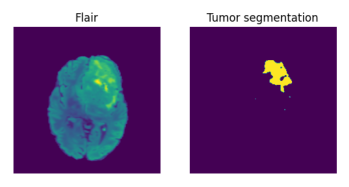

In [2]:
# PONER PNG DE LA IMAGEN 1



from PIL import Image
import matplotlib.pyplot as plt

# Cargar la imagen
imagen = Image.open("./images/imagen1.png")

# Mostrar la imagen
plt.imshow(imagen)
plt.axis('off')
plt.show()

Realizamos una limpieza de la máscara quitando los "blobs" con áreas muy pequeñas sueltas. En el caso de segmentaciones con varios "blobs" grandes, nos quedamos con el de mayor área. Además rellenamos agujeros de dentro de la segmentación con la función `binary_fill_holes`. Finalmente realizamos un "crop" a la imagen, quedándonos únicamente con la zona de interés (tumor). Los casos con mala segmentació (i.e. caso 2) los quitaremos más adelante.

In [ ]:
# Ha dicho que esta no la utilicemos porque es la que da error
def remove_small_blobs(binary_mask: np.ndarray, min_size: int = 0):
    """
    Removes from the input mask all the blobs having less than N adjacent pixels.
    We set the small objects to the background label 0.
    """
    if min_size > 0:
        dtype = binary_mask.dtype
        binary_mask = morphology.remove_small_objects(binary_mask.astype(bool), min_size=min_size)
        binary_mask = binary_mask.astype(dtype)
    return binary_mask

In [ ]:
def keep_bigger_blob(binary_mask: np.ndarray):
    
    labels_mask = label(binary_mask)     
    regions = regionprops(labels_mask)
    regions.sort(key=lambda x: x.area, reverse=True)
    if len(regions) > 1:
        for rg in regions[1:]:
            labels_mask[rg.coords[:,0],rg.coords[:,1],rg.coords[:,2]] = 0
    labels_mask[labels_mask!=0] = 1
    mask = labels_mask
    
    return mask

In [ ]:
image0 = sitk.GetImageFromArray(test_img[0,1,:,:].reshape(1, 256, 256))

mask = np.array([test_res[0][0].detach().cpu().numpy() > 0.5]).astype(np.uint8)
#mask_clean = remove_small_blobs(mask, 100)
mask_clean2 = keep_bigger_blob(mask)
mask_cl = ndimage.binary_fill_holes(mask_clean2[0,:,:]).astype(int)
mask_clean2[0,:,:] = mask_cl
mask_clean2 = sitk.GetImageFromArray(mask_clean2)
# Crop the image
# bb is the bounding box, upon which the image and mask are cropped
bb, correctedMask = imageoperations.checkMask(image0, mask_clean2, label=1)
if correctedMask is not None:
    mask_clean2 = correctedMask
image, mask = imageoperations.cropToTumorMask(image0, mask_clean2, bb)

In [ ]:
msk0 = mask
msk = sitk.GetArrayFromImage(mask)

T1 = test_img[0,0,:,:].reshape(1, 256, 256)
Flair = test_img[0,1,:,:].reshape(1, 256, 256)
T1wce = test_img[0,2,:,:].reshape(1, 256, 256)

f, axarr = plt.subplots(1,4, figsize=(20, 20))
axarr[0].imshow(T1[0,:,:])
axarr[0].set_title('T1 %s' %(ind))
axarr[0].axis('off')
axarr[1].imshow(Flair[0,:,:])
axarr[1].set_title('Flair %s' %(ind))
axarr[1].axis('off')
axarr[2].imshow(T1wce[0,:,:])
axarr[2].set_title('T1wce %s' %(ind))
axarr[2].axis('off')
#axarr[3].imshow(mask_clean[0,:,:])
#axarr[3].set_title('Mask1 %s' %(ind))
#axarr[3].axis('off')
axarr[3].imshow(msk[0,:,:])
axarr[3].set_title('Mask2 %s' %(ind))
axarr[3].axis('off')

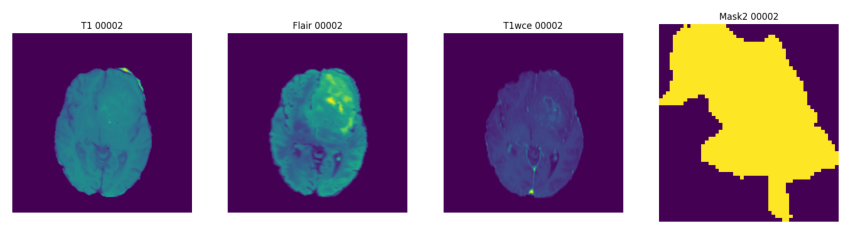

In [14]:


from PIL import Image
import matplotlib.pyplot as plt

# Cargar la imagen
imagen = Image.open("./images/imagen2.png")
plt.figure(figsize=(15, 15))

# Mostrar la imagen
plt.imshow(imagen)
plt.axis('off')
plt.show()

### Extraemos las características de radiómica.

Para extraer las características, podemos elegir cualquiera de las 3 secuencias disponibles y la máscara de segmentación obtenida. En este ejemplo vamos a extraer las características de primer orden de una imagen utilizando la secuencia *Flair*. Fíjate que la librería pyRadiomics necesita imágenes sitk como entrada. Revisa la librería pyradiomics para ver todas las características que puedes extraer (https://pyradiomics.readthedocs.io/en/latest/features.html).

In [ ]:
firstOrderFeatures = radiomics.firstorder.RadiomicsFirstOrder(image, mask)
# Extraemos todas las características de la categoría First Order:
firstOrderFeatures.enableAllFeatures()
# Calcula las características y hace el print
print('Calculating first order features...',)
result = firstOrderFeatures.execute()
print('done')
print(result)

In [ ]:
data = pd.DataFrame(list(result.values()))
data = data.T  
data.columns = list(result.keys())
data

# TAREA

1.- Extraer todas las características posibles con la librería pyradiomics.

2.- Implementar estrategias de selección de características para reducir el número de características.

3.- Aplicar un clasificador que permita distinguir entre los dos tipos de tumores.

4.- Guardar las predicciones del dataset de test (los 100 últimos casos) en un csv y subirlo a la plataforma cuyo enlace se encuentra en el AV.

5.- Escribir un documento en formato artículo científico (template en el AV) con los siguientes apartados: 1.Introducción, 2.Material y métodos, 3.Resultados, 4.Discusión y 5.Conclusiones.

6.- Subir el artículo y el notebook al AV.

-----------------------------

Para cada una de las 3 secuencias de imágenes de RM  (T1, FLAIR y T1wce), se pueden extraer diferentes características para su análisis. Estas características  proporcionan información importante sobre la estructura y composición de los tejidos cerebrales en cada secuencia. Concretamente, se trata de características de textura y de forma que puede caracterizar el tumor y diferenciarlo del resto de tejido sano.

In [ ]:

# carga lista ordenada de los archivos
dataset_dirs = sorted(os.listdir(dataset_path))
dataset_dirs2 = [i for i in dataset_dirs if i not in rem_cases]

In [ ]:
def get_img(index):
    
    ind = dataset_dirs2[index]
    
    
    filenamesDICOM = reader.GetGDCMSeriesFileNames(f'{dataset_path}/{dataset_dirs2[index]}/T1w')
    reader.SetFileNames(filenamesDICOM)
    t1_sitk = reader.Execute()

    filenamesDICOM = reader.GetGDCMSeriesFileNames(f'{dataset_path}/{dataset_dirs2[index]}/FLAIR')
    reader.SetFileNames(filenamesDICOM)
    flair_sitk = reader.Execute()

    filenamesDICOM = reader.GetGDCMSeriesFileNames(f'{dataset_path}/{dataset_dirs2[index]}/T1wCE')
    reader.SetFileNames(filenamesDICOM)
    t1wce_sitk = reader.Execute()

    flair_resampled = resample(flair_sitk, t1_sitk)
    t1wce_resampled = resample(t1wce_sitk, t1_sitk)

    t1_sitk_array = normalizeImage(sitk.GetArrayFromImage(t1_sitk))
    flair_resampled_array = normalizeImage(sitk.GetArrayFromImage(flair_resampled))
    t1wce_resampled_array = normalizeImage(sitk.GetArrayFromImage(t1wce_resampled))

    stacked = np.stack([t1_sitk_array, flair_resampled_array, t1wce_resampled_array])

    to_rgb = stacked[:,t1_sitk_array.shape[0]//2,:,:].transpose(1,2,0)
    im = Image.fromarray((to_rgb * 255).astype(np.uint8))
    return im


In [ ]:
imagenes = []
dfs =  []

for i in range(len(dataset_dirs2)):
    imagen = get_img(i)
    test_img = np.array([np.moveaxis(np.array(imagen.resize((256, 256))), -1, 0)])
    test_res = model(torch.Tensor(test_img))

    image = sitk.GetImageFromArray(test_img[0,1,:,:].reshape(1, 256, 256))
    mask = sitk.GetImageFromArray(np.array([
            test_res[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8))

    im = sitk.GetArrayFromImage(image)
    msk = sitk.GetArrayFromImage(mask)

    image0 = sitk.GetImageFromArray(test_img[0,1,:,:].reshape(1, 256, 256))

    mask = np.array([test_res[0][0].detach().cpu().numpy() > 0.5]).astype(np.uint8)
    #mask_clean = remove_small_blobs(mask, 100)
    mask_clean2 = keep_bigger_blob(mask)
    mask_cl = ndimage.binary_fill_holes(mask_clean2[0,:,:]).astype(int)
    mask_clean2[0,:,:] = mask_cl
    mask_clean2 = sitk.GetImageFromArray(mask_clean2)
    # Crop the image
    # bb is the bounding box, upon which the image and mask are cropped
    bb, correctedMask = imageoperations.checkMask(image0, mask_clean2, label=1)
    if correctedMask is not None:
        mask_clean2 = correctedMask
    image, mask = imageoperations.cropToTumorMask(image0, mask_clean2, bb)

    msk0 = mask
    msk = sitk.GetArrayFromImage(mask)

    T1 = test_img[0,0,:,:].reshape(1, 256, 256)
    Flair = test_img[0,1,:,:].reshape(1, 256, 256)
    T1wce = test_img[0,2,:,:].reshape(1, 256, 256)

    # hacer todo excpto2D
    firstOrderFeatures = radiomics.firstorder.RadiomicsFirstOrder(image, mask)
    # Extraemos todas las características de la categoría First Order:
    firstOrderFeatures.enableAllFeatures()
    # Calcula las características y hace el print
    result = firstOrderFeatures.execute()
    
    data = pd.DataFrame(list(result.values()))
    data = data.T  
    data.columns = list(result.keys())
    
    dfs.append(data)
    print(i)
dfs = pd.concat(dfs) # de lista a pd/df
    

In [ ]:
np.array([np.moveaxis(np.array(get_img(0).resize((256, 256))), -1, 0)]).shape

In [ ]:
imagenes = []
dfs1st =  []
dfs3d = []
dfsGLCM = []
dfsGLSZM = []
dfsGLRLM = []
dfsNGTDM = []
dfsGLDM = []

df_final = []


for i in range(len(dataset_dirs2)):
# for i in range(2):
    imagen = get_img(i)
    test_img = np.array([np.moveaxis(np.array(imagen.resize((256, 256))), -1, 0)])


    T1 = test_img[0,0,:,:].reshape(1, 256, 256)
    Flair = test_img[0,1,:,:].reshape(1, 256, 256)
    T1wce = test_img[0,2,:,:].reshape(1, 256, 256)
    
    seqs = [T1, Flair, T1wce]
    
    dfs1st = []
    dfs3d = []
    dfsGLCM = []
    dfsGLSZM = []
    dfsGLRLM = []
    dfsNGTDM = []
    dfsGLDM = []

    for j in range(3):
    
        test_res = model(torch.Tensor(test_img))

        image = sitk.GetImageFromArray(seqs[j])
        mask = sitk.GetImageFromArray(np.array([
                test_res[0][0].detach().cpu().numpy() > 0.5
            ]).astype(np.uint8))

        im = sitk.GetArrayFromImage(image)
        msk = sitk.GetArrayFromImage(mask)

        image0 = sitk.GetImageFromArray(seqs[j])

        mask = np.array([test_res[0][0].detach().cpu().numpy() > 0.5]).astype(np.uint8)
        #mask_clean = remove_small_blobs(mask, 100)
        mask_clean2 = keep_bigger_blob(mask)
        mask_cl = ndimage.binary_fill_holes(mask_clean2[0,:,:]).astype(int)
        mask_clean2[0,:,:] = mask_cl
        mask_clean2 = sitk.GetImageFromArray(mask_clean2)
        # Crop the image
        # bb is the bounding box, upon which the image and mask are cropped
        bb, correctedMask = imageoperations.checkMask(image0, mask_clean2, label=1)
        if correctedMask is not None:
            mask_clean2 = correctedMask
        image, mask = imageoperations.cropToTumorMask(image0, mask_clean2, bb)

        msk0 = mask
        msk = sitk.GetArrayFromImage(mask)


        ##### ------  CARACTERISTICAS ------------------

        # -------------- firstOrderFeatures

        firstOrderFeatures = radiomics.firstorder.RadiomicsFirstOrder(image, mask)
        # Extraemos todas las características de la categoría First Order:
        firstOrderFeatures.enableAllFeatures()
        # Calcula las características y hace el print
        result1st = firstOrderFeatures.execute()

        data1st = pd.DataFrame(list(result1st.values()))
        data1st = data1st.T  
        data1st.columns = list(result1st.keys())

        dfs1st.append(data1st)

        # -------------- shape 3d

        shape3d = radiomics.shape.RadiomicsShape(image, mask)

        shape3d.enableAllFeatures()
        result3d = shape3d.execute()

        data3d = pd.DataFrame(list(result3d.values()))
        data3d = data3d.T  
        data3d.columns = list(result3d.keys())

        dfs3d.append(data3d)

        # -------------- GLCM

        GLCM = radiomics.glcm.RadiomicsGLCM(image, mask)

        GLCM.enableAllFeatures()
        resultGLCM = GLCM.execute()

        dataGLCM = pd.DataFrame(list(resultGLCM.values()))
        dataGLCM = dataGLCM.T  
        dataGLCM.columns = list(resultGLCM.keys())

        dfsGLCM.append(dataGLCM)

        # -------------- GLSZM
        GLSZM = radiomics.glszm.RadiomicsGLSZM(image, mask)

        GLSZM.enableAllFeatures()
        resultGLSZM = GLSZM.execute()

        dataGLSZM = pd.DataFrame(list(resultGLSZM.values()))
        dataGLSZM = dataGLSZM.T  
        dataGLSZM.columns = list(resultGLSZM.keys())

        dfsGLSZM.append(dataGLSZM)

        # -------------- GLRLM

        GLRLM = radiomics.glrlm.RadiomicsGLRLM(image, mask)

        GLRLM.enableAllFeatures()
        resultGLRLM = GLRLM.execute()

        dataGLRLM = pd.DataFrame(list(resultGLRLM.values()))
        dataGLRLM = dataGLRLM.T  
        dataGLRLM.columns = list(resultGLRLM.keys())

        dfsGLRLM.append(dataGLRLM)

        # -------------- NGTDM

        NGTDM = radiomics.ngtdm.RadiomicsNGTDM(image, mask)

        NGTDM.enableAllFeatures()
        resultNGTDM = NGTDM.execute()

        dataNGTDM = pd.DataFrame(list(resultNGTDM.values()))
        dataNGTDM = dataNGTDM.T  
        dataNGTDM.columns = list(resultNGTDM.keys())

        dfsNGTDM.append(dataNGTDM)

        # -------------- GLDM


        GLDM = radiomics.gldm.RadiomicsGLDM(image, mask)

        GLDM.enableAllFeatures()
        resultGLDM = GLDM.execute()

        dataGLDM = pd.DataFrame(list(resultGLDM.values()))
        dataGLDM = dataGLDM.T  
        dataGLDM.columns = list(resultGLDM.keys())

        dfsGLDM.append(dataGLDM)


        print('seq',j)
    
    dfs1st = pd.concat(dfs1st)
    dfs3d = pd.concat(dfs3d)
    dfsGLCM = pd.concat(dfsGLCM)
    dfsGLSZM = pd.concat(dfsGLSZM)
    dfsGLRLM = pd.concat(dfsGLRLM)
    dfsNGTDM = pd.concat(dfsNGTDM)
    dfsGLDM = pd.concat(dfsGLDM)
    DFS = [dfs1st, dfs3d, dfsGLCM, dfsGLSZM, dfsGLRLM, dfsNGTDM, dfsGLDM]
    DFS = pd.concat(DFS, axis=1)
    df_final.append(DFS)

    print('img', i)

In [ ]:
import pandas as pd

sufijos = ['_T1', '_Flair', '_t1wce']

dataframes_f = []
for i in range(len(df_final)):
    # Concatenar todas las filas del dataframe en una sola fila
    fila_concatenada = pd.concat([df_final[i].iloc[j] for j in range(len(df_final[i]))], axis=0)

    # Obtener los nombres de las variables originales
    nombres_originales = df_final[0].columns

    # Crear los nuevos nombres de las columnas
    nuevos_nombres = []
    for nombre in nombres_originales:
        nuevos_nombres.extend([nombre + sufijo for sufijo in sufijos])

    # Asignar los nuevos nombres de las columnas
    fila_concatenada.index = nuevos_nombres

    # Crear un nuevo dataframe con una sola fila
    nuevo_dataframe = pd.DataFrame(fila_concatenada)
    
    dataframes_f.append(nuevo_dataframe.T)

In [ ]:
df_final = pd.concat(dataframes_f, axis=0)
df_final

In [ ]:
df_final.to_csv('/kaggle/working/df_radiomica.csv', index=False)


CARACTERÍSTICAS EXTRAIDAS, PARA CADA UNA DE LAS 3 SECUENCIAS (T1, Flair, t1wce)

First Order Statistics (19 features) <br>
Shape-based (3D) (16 features)<br>
Gray Level Cooccurence Matrix (24 features)<br>
Gray Level Run Length Matrix (16 features)<br>
Gray Level Size Zone Matrix (16 features)<br>
Neighbouring Gray Tone Difference Matrix (5 features)<br>
Gray Level Dependence Matrix (14 features)

321 características en total

Difiere porque se han eliminado 2D


#### Ahora se obtienen las mismas características originales, pero previamente se aplica un  filtro wavelet ya que puede potenicar detalles de la imagen que sin un filtrado previo no se puedan distinguir.

In [ ]:
from __future__ import print_function

import logging

import numpy as np
import pywt
import SimpleITK as sitk
import six
from six.moves import range

In [ ]:
logger = logging.getLogger(__name__)

Se definen funciones para la obtención de las imágenes con el filtro.

In [ ]:
def getWaveletImage(inputImage, inputMask, **kwargs):
  """
  Applies wavelet filter to the input image and yields the decompositions and the approximation.

  Following settings are possible:

  - start_level [0]: integer, 0 based level of wavelet which should be used as first set of decompositions
    from which a signature is calculated
  - level [1]: integer, number of levels of wavelet decompositions from which a signature is calculated.
  - wavelet ["coif1"]: string, type of wavelet decomposition. Enumerated value, validated against possible values
    present in the ``pyWavelet.wavelist()``. Current possible values (pywavelet version 0.4.0) (where an
    aditional number is needed, range of values is indicated in []):

    - haar
    - dmey
    - sym[2-20]
    - db[1-20]
    - coif[1-5]
    - bior[1.1, 1.3, 1.5, 2.2, 2.4, 2.6, 2.8, 3.1, 3.3, 3.5, 3.7, 3.9, 4.4, 5.5, 6.8]
    - rbio[1.1, 1.3, 1.5, 2.2, 2.4, 2.6, 2.8, 3.1, 3.3, 3.5, 3.7, 3.9, 4.4, 5.5, 6.8]

  Returned filter name reflects wavelet type:
  wavelet[level]-<decompositionName>

  N.B. only levels greater than the first level are entered into the name.

  :return: Yields each wavelet decomposition and final approximation, corresponding imaget type name and ``kwargs``
    (customized settings).
  """
  global logger

  logger.debug('Generating Wavelet images')

  Nd = inputImage.GetDimension()
  axes = list(range(Nd - 1, -1, -1))
  if kwargs.get('force2D', False):
    axes.remove(kwargs.get('force2Ddimension', 0))

  approx, ret = _swt3(inputImage, tuple(axes), **kwargs)

  for idx, wl in enumerate(ret, start=1):
    for decompositionName, decompositionImage in wl.items():
      logger.info('Computing Wavelet %s', decompositionName)

      if idx == 1:
        inputImageName = 'wavelet-%s' % (decompositionName)
      else:
        inputImageName = 'wavelet%s-%s' % (idx, decompositionName)
      logger.debug('Yielding %s image', inputImageName)
      return decompositionImage, inputImageName, kwargs

  if len(ret) == 1:
    inputImageName = 'wavelet-%s' % ('L' * len(axes))
  else:
    inputImageName = 'wavelet%s-%s' % (len(ret), ('L' * len(axes)))
  logger.debug('Yielding approximation (%s) image', inputImageName)
  return approx, inputImageName, kwargs

In [ ]:
def _swt3(inputImage, axes, **kwargs):  # Stationary Wavelet Transform 3D
  wavelet = kwargs.get('wavelet', 'coif1')
  level = kwargs.get('level', 1)
  start_level = kwargs.get('start_level', 0)

  matrix = sitk.GetArrayFromImage(inputImage)  # This function gets a numpy array from the SimpleITK Image "inputImage"
  matrix = np.asarray(matrix) # The function np.asarray converts "matrix" (which could be also a tuple) into an array.

  original_shape = matrix.shape
  # original_shape becomes a tuple (?,?,?) containing the number of rows, columns, and slices of the image
  # this is of course dependent on the number of dimensions, but the same principle holds
  padding = tuple([(0, 1 if dim % 2 != 0 else 0) for dim in original_shape])
  # padding is necessary because of pywt.swtn (see function Notes)
  data = matrix.copy()  # creates a modifiable copy of "matrix" and we call it "data"
  data = np.pad(data, padding, 'wrap')  # padding the tuple "padding" previously computed

  if not isinstance(wavelet, pywt.Wavelet):
    wavelet = pywt.Wavelet(wavelet)

  for i in range(0, start_level):  # if start_level = 0 (default) this for loop never gets executed
    # compute all decompositions and saves them in "dec" dict
    dec = pywt.swtn(data, wavelet, level=1, start_level=0, axes=axes)[0]
    # copies in "data" just the "aaa" decomposition (i.e. approximation; No of consecutive 'a's = len(axes))
    data = dec['a' * len(axes)].copy()

  ret = []  # initialize empty list
  for i in range(start_level, start_level + level):
    # compute the n-dimensional stationary wavelet transform
    dec = pywt.swtn(data, wavelet, level=1, start_level=0, axes=axes)[0]
    # Copy the approximation into data (approximation in output / input for next levels)
    data = dec['a' * len(axes)].copy()

    dec_im = {}  # initialize empty dict
    for decName, decImage in six.iteritems(dec):
      # Returning the approximiation is done only for the last loop,
      # and is handled separately below (by building it from `data`)
      # There for, skip it here
      if decName == 'a' * len(axes):
        continue
      decTemp = decImage.copy()
      decTemp = decTemp[tuple(slice(None, -1 if dim % 2 != 0 else None) for dim in original_shape)]
      sitkImage = sitk.GetImageFromArray(decTemp)
      sitkImage.CopyInformation(inputImage)
      dec_im[str(decName).replace('a', 'L').replace('d', 'H')] = sitkImage
      # modifies 'a' with 'L' (Low-pass filter) and 'd' with 'H' (High-pass filter)

    ret.append(dec_im)  # appending all the filtered sitk images (stored in "dec_im") to the "ret" list

  data = data[tuple(slice(None, -1 if dim % 2 != 0 else None) for dim in original_shape)]
  approximation = sitk.GetImageFromArray(data)
  approximation.CopyInformation(inputImage)

  return approximation, ret  # returns the approximation and the detail (ret) coefficients of the stationary wavelet decomposition

In [ ]:
imagenes = []
dfs1st =  []
dfs3d = []
dfsGLCM = []
dfsGLSZM = []
dfsGLRLM = []
dfsNGTDM = []
dfsGLDM = []


IMG_wavelets = []
df_final_wavelets = []


for i in range(len(dataset_dirs2)):
# for i in range(2):
    imagen = get_img(i)
    test_img = np.array([np.moveaxis(np.array(imagen.resize((256, 256))), -1, 0)])

    T1 = test_img[0,0,:,:].reshape(1, 256, 256)
    Flair = test_img[0,1,:,:].reshape(1, 256, 256)
    T1wce = test_img[0,2,:,:].reshape(1, 256, 256)
    
    seqs = [T1, Flair, T1wce]
    
    dfs1st = []
    dfs3d = []
    dfsGLCM = []
    dfsGLSZM = []
    dfsGLRLM = []
    dfsNGTDM = []
    dfsGLDM = []
    wavelets = []

    for j in range(3):
    
        test_res = model(torch.Tensor(test_img))

        image = sitk.GetImageFromArray(seqs[j])
        mask = sitk.GetImageFromArray(np.array([
                test_res[0][0].detach().cpu().numpy() > 0.5
            ]).astype(np.uint8))
        
        

        im = sitk.GetArrayFromImage(image)
        msk = sitk.GetArrayFromImage(mask)

        image0 = sitk.GetImageFromArray(seqs[j])

        mask = np.array([test_res[0][0].detach().cpu().numpy() > 0.5]).astype(np.uint8)
        #mask_clean = remove_small_blobs(mask, 100)
        mask_clean2 = keep_bigger_blob(mask)
        mask_cl = ndimage.binary_fill_holes(mask_clean2[0,:,:]).astype(int)
        mask_clean2[0,:,:] = mask_cl
        mask_clean2 = sitk.GetImageFromArray(mask_clean2)
        # Crop the image
        # bb is the bounding box, upon which the image and mask are cropped
        bb, correctedMask = imageoperations.checkMask(image0, mask_clean2, label=1)
        if correctedMask is not None:
            mask_clean2 = correctedMask
        image, mask = imageoperations.cropToTumorMask(image0, mask_clean2, bb)

        msk0 = mask
        msk = sitk.GetArrayFromImage(mask)

        wavelet = getWaveletImage(image, mask)
        
        ##### ------  CARACTERISTICAS ------------------
    
        
        
        # -------------- firstOrderFeatures

        firstOrderFeatures = radiomics.firstorder.RadiomicsFirstOrder(wavelet[0], mask)
        # Extraemos todas las características de la categoría First Order:
        firstOrderFeatures.enableAllFeatures()
        # Calcula las características y hace el print
        result1st = firstOrderFeatures.execute()

        data1st = pd.DataFrame(list(result1st.values()))
        data1st = data1st.T  
        data1st.columns = list(result1st.keys())

        dfs1st.append(data1st)

        # -------------- shape 3d

        shape3d = radiomics.shape.RadiomicsShape(wavelet[0], mask)

        shape3d.enableAllFeatures()
        result3d = shape3d.execute()

        data3d = pd.DataFrame(list(result3d.values()))
        data3d = data3d.T  
        data3d.columns = list(result3d.keys())

        dfs3d.append(data3d)

        # -------------- GLCM

        GLCM = radiomics.glcm.RadiomicsGLCM(wavelet[0], mask)

        GLCM.enableAllFeatures()
        resultGLCM = GLCM.execute()

        dataGLCM = pd.DataFrame(list(resultGLCM.values()))
        dataGLCM = dataGLCM.T  
        dataGLCM.columns = list(resultGLCM.keys())

        dfsGLCM.append(dataGLCM)

        # -------------- GLSZM
        GLSZM = radiomics.glszm.RadiomicsGLSZM(wavelet[0], mask)

        GLSZM.enableAllFeatures()
        resultGLSZM = GLSZM.execute()

        dataGLSZM = pd.DataFrame(list(resultGLSZM.values()))
        dataGLSZM = dataGLSZM.T  
        dataGLSZM.columns = list(resultGLSZM.keys())

        dfsGLSZM.append(dataGLSZM)

        # -------------- GLRLM

        GLRLM = radiomics.glrlm.RadiomicsGLRLM(wavelet[0], mask)

        GLRLM.enableAllFeatures()
        resultGLRLM = GLRLM.execute()

        dataGLRLM = pd.DataFrame(list(resultGLRLM.values()))
        dataGLRLM = dataGLRLM.T  
        dataGLRLM.columns = list(resultGLRLM.keys())

        dfsGLRLM.append(dataGLRLM)

        # -------------- NGTDM

        NGTDM = radiomics.ngtdm.RadiomicsNGTDM(wavelet[0], mask)

        NGTDM.enableAllFeatures()
        resultNGTDM = NGTDM.execute()

        dataNGTDM = pd.DataFrame(list(resultNGTDM.values()))
        dataNGTDM = dataNGTDM.T  
        dataNGTDM.columns = list(resultNGTDM.keys())

        dfsNGTDM.append(dataNGTDM)

        # -------------- GLDM


        GLDM = radiomics.gldm.RadiomicsGLDM(wavelet[0], mask)

        GLDM.enableAllFeatures()
        resultGLDM = GLDM.execute()

        dataGLDM = pd.DataFrame(list(resultGLDM.values()))
        dataGLDM = dataGLDM.T  
        dataGLDM.columns = list(resultGLDM.keys())

        dfsGLDM.append(dataGLDM)


        print('seq',j)
    
    dfs1st = pd.concat(dfs1st)
    dfs3d = pd.concat(dfs3d)
    dfsGLCM = pd.concat(dfsGLCM)
    dfsGLSZM = pd.concat(dfsGLSZM)
    dfsGLRLM = pd.concat(dfsGLRLM)
    dfsNGTDM = pd.concat(dfsNGTDM)
    dfsGLDM = pd.concat(dfsGLDM)
    DFS = [dfs1st, dfs3d, dfsGLCM, dfsGLSZM, dfsGLRLM, dfsNGTDM, dfsGLDM]
    DFS = pd.concat(DFS, axis=1)
    df_final_wavelets.append(DFS)
    IMG_wavelets.append(wavelets)

    print('img', i)

In [ ]:
import pandas as pd

sufijos = ['_T1_wavelet', '_Flair_wavelet', '_t1wce_wavelet']

dataframes_f = []
for i in range(len(df_final_wavelets)):
    # Concatenar todas las filas del dataframe en una sola fila
    fila_concatenada = pd.concat([df_final_wavelets[i].iloc[j] for j in range(len(df_final_wavelets[i]))], axis=0)

    # Obtener los nombres de las variables originales
    nombres_originales = df_final_wavelets[0].columns

    # Crear los nuevos nombres de las columnas
    nuevos_nombres = []
    for nombre in nombres_originales:
        nuevos_nombres.extend([nombre + sufijo for sufijo in sufijos])

    # Asignar los nuevos nombres de las columnas
    fila_concatenada.index = nuevos_nombres

    # Crear un nuevo dataframe con una sola fila
    nuevo_dataframe = pd.DataFrame(fila_concatenada)
    
    dataframes_f.append(nuevo_dataframe.T)

In [ ]:
df_final_wavelets = pd.concat(dataframes_f, axis=0)
df_final_wavelets

In [ ]:
df1 = pd.read_csv('/kaggle/working/df_radiomica.csv')
df2 = pd.read_csv('/kaggle/working/df_wavelets_radiomica.csv')

DF_FINAL_RADIOMICA = pd.concat([df1, df2], axis=1)

DF_FINAL_RADIOMICA.to_csv('/kaggle/working/DF_FINAL_RADIOMICA.csv', index=False)
DF_FINAL_RADIOMICA

De este modo se logra obtener el dataframe final de características con el que se pasa a trabajar.

LINK AL CUADERNO DE KAGGLE DONDE SE ENCUENTRA EJECUTADO <br>
(En local no es viable por tamaño) <br>
https://www.kaggle.com/code/cayetano108/prueba-radiomica

## 1. Carga de datos

En primer lugar se cargan todas las características de radiómica de todas las imágenes. De estas, se obteien el conjunto de train y el de test, que se utilizará para subirlo y compararlo con las etiquetas del Challenge de la asignatura. 


In [2]:
import pandas as pd
datos= pd.read_csv("DF_FINAL_RADIOMICA.csv")

# Test: Crear una nueva variable para almacenar los últimos 100 elementos
datos_test = datos.tail(100)

# Train: Eliminar los últimos 100 elementos del DataFrame original
datos_train = datos.drop(datos.tail(100).index)
print(datos_train.shape)
datos_train.head()

(384, 642)


,10Percentile_T1,10Percentile_Flair,10Percentile_t1wce,90Percentile_T1,90Percentile_Flair,90Percentile_t1wce,Energy_T1,Energy_Flair,Energy_t1wce,Entropy_T1,...,LowGrayLevelEmphasis_t1wce_wavelet,SmallDependenceEmphasis_T1_wavelet,SmallDependenceEmphasis_Flair_wavelet,SmallDependenceEmphasis_t1wce_wavelet,SmallDependenceHighGrayLevelEmphasis_T1_wavelet,SmallDependenceHighGrayLevelEmphasis_Flair_wavelet,SmallDependenceHighGrayLevelEmphasis_t1wce_wavelet,SmallDependenceLowGrayLevelEmphasis_T1_wavelet,SmallDependenceLowGrayLevelEmphasis_Flair_wavelet,SmallDependenceLowGrayLevelEmphasis_t1wce_wavelet
0,107.0,137.0,28346687.0,1.148016,15.0,3.269895,161.0,9.507846,119.574414,118.0,...,1920.449541,0.010589,3.967890,72.992864,291.930173,18.258537,0.258028,0.024673,0.068876,0.013622
1,91.0,110.0,14504955.0,1.156347,10.0,8.218238,116.0,6.551715,99.844075,100.0,...,1415.271656,0.009608,3.970894,72.854470,291.376299,18.224012,0.257277,0.023456,0.067837,0.012361
2,68.0,97.0,10945975.0,1.029655,14.0,2.453209,111.0,8.234437,83.974493,84.0,...,1495.378025,0.010995,3.966645,72.775016,291.054938,18.205036,0.258339,0.024789,0.068743,0.013800
3,144.0,177.0,86205891.0,1.280874,17.0,3.333962,203.0,10.036525,159.901791,159.0,...,3280.731343,0.010339,3.968657,75.189254,300.714925,18.807836,0.257836,0.023403,0.064953,0.013015
4,55.7,119.0,11725863.0,1.288423,12.0,7.025549,130.0,18.064797,100.717069,110.0,...,1062.118738,0.007366,3.977737,73.552876,294.189239,18.393785,0.255566,0.022041,0.065902,0.011076


In [163]:
print(datos_test.shape)
datos_test.head()

(100, 642)


,10Percentile_T1,10Percentile_Flair,10Percentile_t1wce,90Percentile_T1,90Percentile_Flair,90Percentile_t1wce,Energy_T1,Energy_Flair,Energy_t1wce,Entropy_T1,...,LowGrayLevelEmphasis_t1wce_wavelet,SmallDependenceEmphasis_T1_wavelet,SmallDependenceEmphasis_Flair_wavelet,SmallDependenceEmphasis_t1wce_wavelet,SmallDependenceHighGrayLevelEmphasis_T1_wavelet,SmallDependenceHighGrayLevelEmphasis_Flair_wavelet,SmallDependenceHighGrayLevelEmphasis_t1wce_wavelet,SmallDependenceLowGrayLevelEmphasis_T1_wavelet,SmallDependenceLowGrayLevelEmphasis_Flair_wavelet,SmallDependenceLowGrayLevelEmphasis_t1wce_wavelet
384,92.0,112.0,46351427.0,1.068929,10.0,3.927619,134.0,6.311238,101.282914,101.0,...,4364.768323,0.013837,3.957897,75.054801,300.169080,18.776231,0.260526,0.027061,0.068145,0.016790
385,78.7,132.0,4630179.0,1.745816,24.0,2.966005,157.0,16.068965,108.764550,112.5,...,364.259259,0.018176,3.944444,68.666667,274.563492,17.192460,0.263889,0.030641,0.078915,0.018573
386,99.0,150.0,8010035.0,1.756970,31.0,2.097789,163.0,16.471446,126.140244,129.0,...,480.146341,0.012046,3.963415,70.378049,281.475610,17.603659,0.259146,0.027613,0.073865,0.016049
387,61.0,144.0,6511595.0,2.316584,48.0,2.083665,165.0,25.393033,102.397548,103.0,...,567.014011,0.003490,3.989492,70.117338,280.458844,17.531961,0.252627,0.019888,0.069043,0.007599
388,111.0,173.0,20078448.0,1.555887,23.0,3.009882,192.0,18.605730,130.174064,120.0,...,1131.140992,0.007772,3.976501,74.035683,296.119234,18.514795,0.255875,0.022262,0.065550,0.011440


In [3]:
train_label = pd.read_csv("train_labels.csv")
train_label.head(5)
train_label.shape


(384, 2)

## 2. Análisi exploratorio de datos

Se realiza en segundo lugar el análisis exploratprio de datos con el fin de estudiar y poder eliminar aquellas anomalías o factores que puedan confundir a los modelos en el proceso de aprendizaje. 

In [165]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Revisar la información general del conjunto de datos
datos_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Columns: 642 entries, 10Percentile_T1 to SmallDependenceLowGrayLevelEmphasis_t1wce_wavelet
dtypes: float64(642)
memory usage: 1.9 MB


In [166]:
# Obtener un resumen estadístico de las variables numéricas
datos_train.describe()


,10Percentile_T1,10Percentile_Flair,10Percentile_t1wce,90Percentile_T1,90Percentile_Flair,90Percentile_t1wce,Energy_T1,Energy_Flair,Energy_t1wce,Entropy_T1,...,LowGrayLevelEmphasis_t1wce_wavelet,SmallDependenceEmphasis_T1_wavelet,SmallDependenceEmphasis_Flair_wavelet,SmallDependenceEmphasis_t1wce_wavelet,SmallDependenceHighGrayLevelEmphasis_T1_wavelet,SmallDependenceHighGrayLevelEmphasis_Flair_wavelet,SmallDependenceHighGrayLevelEmphasis_t1wce_wavelet,SmallDependenceLowGrayLevelEmphasis_T1_wavelet,SmallDependenceLowGrayLevelEmphasis_Flair_wavelet,SmallDependenceLowGrayLevelEmphasis_t1wce_wavelet
count,384.000000,384.000000,3.840000e+02,3.840000e+02,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,...,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000
mean,91.615104,129.689583,2.069734e+07,1.320541e+00,19.498047,4.213379,151.760417,11.949813,110.798878,111.002604,...,1526.712182,0.010480,3.905495,71.486649,281.773387,18.914965,0.273626,0.024633,0.069535,0.013407
std,28.246577,31.838753,2.044700e+07,5.038445e-01,11.826621,3.811495,35.937862,6.265736,28.420916,29.170942,...,1028.865357,0.007636,0.425128,3.369847,34.138592,6.860667,0.106282,0.004008,0.009758,0.003767
min,0.000000,0.000000,0.000000e+00,-3.203427e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,103.000000,0.000000,1.000000,55.064865,55.116505,13.774324,0.251157,0.016437,0.016437,0.005428
25%,75.000000,109.000000,8.257080e+06,1.019543e+00,12.000000,2.722392,129.000000,7.482905,92.625404,92.000000,...,673.033506,0.007512,3.960826,70.272908,280.900218,17.626046,0.255813,0.021981,0.065983,0.011002
50%,91.000000,132.000000,1.509183e+07,1.355648e+00,18.000000,3.328639,153.500000,11.237204,111.044154,111.500000,...,1353.321997,0.009922,3.969548,72.306491,289.210112,18.153922,0.257613,0.024366,0.069269,0.013110
75%,109.000000,150.400000,2.716794e+07,1.677598e+00,24.000000,4.492465,179.000000,15.212811,127.999874,129.000000,...,2159.857278,0.012433,3.976746,73.693378,294.735685,18.464735,0.259793,0.026890,0.073348,0.015762
max,183.000000,244.000000,1.643009e+08,2.771136e+00,109.000000,39.944620,254.000000,48.551801,222.364888,231.000000,...,5449.011523,0.127615,3.995370,76.341422,305.010609,70.677130,1.000000,0.039892,0.098077,0.026366


In [169]:
# Identificar valores nulos o faltantes en el conjunto de datos
datos_train.isnull().sum()

10Percentile_T1                                       0
10Percentile_Flair                                    0
10Percentile_t1wce                                    0
90Percentile_T1                                       0
90Percentile_Flair                                    0
                                                     ..
SmallDependenceHighGrayLevelEmphasis_Flair_wavelet    0
SmallDependenceHighGrayLevelEmphasis_t1wce_wavelet    0
SmallDependenceLowGrayLevelEmphasis_T1_wavelet        0
SmallDependenceLowGrayLevelEmphasis_Flair_wavelet     0
SmallDependenceLowGrayLevelEmphasis_t1wce_wavelet     0
Length: 642, dtype: int64

In [12]:
import pandas as pd
import numpy as np

def eliminar_outliers(data, columnas, umbral=1.5):
    data_sin_outliers = data.copy()
    
    for columna in columnas:
        q1 = data[columna].quantile(0.25)
        q3 = data[columna].quantile(0.75)
        iqr = q3 - q1
        umbral_inferior = q1 - umbral * iqr
        umbral_superior = q3 + umbral * iqr
        
        # Filtrar los registros que están dentro de los límites de Tukey
        data_sin_outliers = data_sin_outliers[(data_sin_outliers[columna] >= umbral_inferior) & (data_sin_outliers[columna] <= umbral_superior)]
    
    return data_sin_outliers

# Columnas numéricas en el conjunto de datos de entrenamiento (datos_train)
columnas_numericas_train = datos_train.select_dtypes(include=np.number).columns

# Ajustar el umbral a un valor mayor
umbral = 20.0

# Eliminar outliers en los datos de entrenamiento (datos_train)
datos_train_sin_outliers = eliminar_outliers(datos_train, columnas_numericas_train, umbral=umbral)

# Obtener los índices de los registros eliminados en los datos de entrenamiento
indices_outliers_train = datos_train.index.difference(datos_train_sin_outliers.index)

# Eliminar los registros correspondientes en las etiquetas de entrenamiento (train_label)
train_label_sin_outliers = train_label.drop(indices_outliers_train)

# Verificar el nuevo tamaño del conjunto de datos de entrenamiento y etiquetas sin outliers
print("Tamaño del conjunto de datos de entrenamiento sin outliers:", datos_train_sin_outliers.shape)
print("Tamaño de las etiquetas de entrenamiento sin outliers:", train_label_sin_outliers.shape)


Tamaño del conjunto de datos de entrenamiento sin outliers: (332, 642)
Tamaño de las etiquetas de entrenamiento sin outliers: (332, 2)


In [13]:
# Realizar análisis de correlación entre variables numéricas

correlation_matrix = datos_train_sin_outliers.corr()
correlation_mask = correlation_matrix.abs() > 0.98 #me quedo con 347 variables
columns_to_drop = []
n_variables = correlation_matrix.shape[0]

for i in range(n_variables):
    for j in range(i + 1, n_variables):
        if correlation_mask.iloc[i, j]:
            column_i = correlation_matrix.columns[i]
            column_j = correlation_matrix.columns[j]
            
            # Verificar si la variable i ya fue marcada para eliminación
            if column_i not in columns_to_drop:
                columns_to_drop.append(column_j)

# Eliminar las columnas seleccionadas
datos_train_filtered = datos_train_sin_outliers.drop(columns=columns_to_drop)
datos_test_filtered = datos_test.drop(columns=columns_to_drop)
print(datos_train_filtered.shape)
print(datos_test_filtered.shape)



(332, 347)
(100, 347)


In [172]:
datos_train_filtered.head()

,10Percentile_T1,10Percentile_Flair,10Percentile_t1wce,90Percentile_T1,90Percentile_Flair,90Percentile_t1wce,Energy_T1,Energy_Flair,Energy_t1wce,Entropy_Flair,...,GrayLevelVariance_Flair_wavelet.2,GrayLevelVariance_t1wce_wavelet.2,HighGrayLevelEmphasis_T1_wavelet,HighGrayLevelEmphasis_Flair_wavelet,HighGrayLevelEmphasis_t1wce_wavelet,LargeDependenceEmphasis_T1_wavelet,LargeDependenceHighGrayLevelEmphasis_T1_wavelet,LargeDependenceHighGrayLevelEmphasis_t1wce_wavelet,LowGrayLevelEmphasis_Flair_wavelet,SmallDependenceLowGrayLevelEmphasis_Flair_wavelet
0,107.0,137.0,28346687.0,1.148016,15.0,3.269895,161.0,9.507846,119.574414,78.0,...,9.051518,0.066430,0.069317,201.171778,0.215144,0.400533,0.047052,0.000227,1.667005,0.068876
1,91.0,110.0,14504955.0,1.156347,10.0,8.218238,116.0,6.551715,99.844075,46.0,...,6.251611,0.061792,0.070166,152.388305,0.189837,0.351851,0.071495,0.000185,1.643328,0.067837
2,68.0,97.0,10945975.0,1.029655,14.0,2.453209,111.0,8.234437,83.974493,62.0,...,6.400434,0.059461,0.070798,150.520163,0.189960,0.292456,0.060856,0.000239,1.649125,0.068743
3,144.0,177.0,86205891.0,1.280874,17.0,3.333962,203.0,10.036525,159.901791,108.0,...,11.729683,0.069593,0.050672,359.192782,0.241413,0.352414,0.028955,0.000213,1.321643,0.064953
5,136.0,174.0,103033322.0,1.463623,19.0,3.146987,197.0,11.693225,154.864459,89.0,...,19.735898,0.094596,0.049507,429.984721,0.297421,0.398104,0.018279,0.000329,1.371918,0.067294


In [173]:
datos_test_filtered.head()

,10Percentile_T1,10Percentile_Flair,10Percentile_t1wce,90Percentile_T1,90Percentile_Flair,90Percentile_t1wce,Energy_T1,Energy_Flair,Energy_t1wce,Entropy_Flair,...,GrayLevelVariance_Flair_wavelet.2,GrayLevelVariance_t1wce_wavelet.2,HighGrayLevelEmphasis_T1_wavelet,HighGrayLevelEmphasis_Flair_wavelet,HighGrayLevelEmphasis_t1wce_wavelet,LargeDependenceEmphasis_T1_wavelet,LargeDependenceHighGrayLevelEmphasis_T1_wavelet,LargeDependenceHighGrayLevelEmphasis_t1wce_wavelet,LowGrayLevelEmphasis_Flair_wavelet,SmallDependenceLowGrayLevelEmphasis_Flair_wavelet
384,92.0,112.0,46351427.0,1.068929,10.0,3.927619,134.0,6.311238,101.282914,60.0,...,23.826770,0.101440,0.052740,413.497343,0.312595,0.456937,0.015960,0.000386,1.471348,0.068145
385,78.7,132.0,4630179.0,1.745816,24.0,2.966005,157.0,16.068965,108.764550,51.0,...,3.911106,0.094963,0.107804,39.930769,0.206270,0.337605,0.160663,0.000623,2.446684,0.078915
386,99.0,150.0,8010035.0,1.756970,31.0,2.097789,163.0,16.471446,126.140244,79.0,...,3.272227,0.072295,0.090955,50.619137,0.161967,0.240022,0.166178,0.000294,1.946146,0.073865
387,61.0,144.0,6511595.0,2.316584,48.0,2.083665,165.0,25.393033,102.397548,37.0,...,4.578222,0.083262,0.091944,52.163744,0.121554,0.367834,0.476001,0.000025,1.816232,0.069043
388,111.0,173.0,20078448.0,1.555887,23.0,3.009882,192.0,18.605730,130.174064,103.0,...,4.351311,0.063618,0.059835,142.333698,0.169478,0.276190,0.111389,0.000122,1.422739,0.065550


## 3. Reducción de la dimensionalidad y modelos de clasificación


Se aplica sobre el conjunto de datos una serie de métodos de reducción de la dimensionaldad, tanto selección como extracción de características, con el fin de obtener las características más relevantes que permitan discernir entre clases. Se debe reducir este número de características ya que se dispone un alto ratio de columnas sobre filas por lo que sin realizar una reducción se daría overfitting. 

Además, en cuanto a la interpretabilidad de los modelos, es deseable tener un número reducido de variables ya que los médicos y en sí los que deben confiar en este resultado se muestran escépticos a un método que funciona con muchas características sin un motivo claro. Por ello, se considera como un valor óptimo 10 características, tratanto de evitar tanto el sobreajuste como buscando la fiabildiad y explicabilidad de los modelos. 



### 3.1 Relief

In [14]:
datos_train_filtered = datos_train_filtered.reset_index(drop=True)
train_label_sin_outliers = train_label_sin_outliers.reset_index(drop=True)


In [15]:
from skrebate import ReliefF
# Crear una instancia del clasificador ReliefF
relief = ReliefF(n_features_to_select=10)
X = datos_train_filtered  # Matriz de características
y=train_label_sin_outliers["MGMT_value"]

# Aplicar el algoritmo Relief a los datos de entrenamiento
X_train_relief = relief.fit_transform(X.values, y)

# Obtener los nombres de las características seleccionadas por ReliefF
nombres_seleccionados = datos_train_filtered.columns[relief.top_features_][:10]

# Crear un DataFrame con las características seleccionadas por ReliefF
datos_train_relief = pd.DataFrame(X_train_relief, columns=nombres_seleccionados)

# Imprimir el DataFrame con las características seleccionadas
print(datos_train_relief.shape)
datos_train_relief.head()

(332, 10)


,Maximum_T1,MeanAbsoluteDeviation_T1,Median_T1,MinorAxisLength_t1wce_wavelet,Minimum_T1,Autocorrelation_T1_wavelet,Maximum3DDiameter_Flair_wavelet,HighGrayLevelEmphasis_T1_wavelet,DependenceNonUniformityNormalized_t1wce,LowGrayLevelZoneEmphasis_Flair_wavelet
0,0.737046,63.929224,47.118792,0.058486,2.123251,1.336635,521.273089,0.069317,0.269647,0.074669
1,0.570947,59.496350,33.969257,0.066528,2.130639,1.508837,399.122331,0.070166,0.470621,0.072245
2,0.662277,60.059987,39.776322,0.070307,2.124345,1.681024,386.104422,0.070798,0.388324,0.078319
3,0.979775,68.270492,66.889692,0.057015,2.075817,1.512552,644.473166,0.050672,0.220440,0.051194
4,0.749365,86.051703,64.484113,0.062074,2.060167,1.721447,586.550851,0.049507,0.468046,0.050975


In [16]:
# Reducir los datos de prueba a las características seleccionadas
datos_test_relief = datos_test[nombres_seleccionados]

# Crear un nuevo DataFrame con las características seleccionadas y sus nombres
datos_test_relief = pd.DataFrame(datos_test_relief, columns=nombres_seleccionados)

# Imprimir el DataFrame con las características seleccionadas para datos de prueba
print(datos_test_relief.shape)
datos_test_relief.head()

(100, 10)


,Maximum_T1,MeanAbsoluteDeviation_T1,Median_T1,MinorAxisLength_t1wce_wavelet,Minimum_T1,Autocorrelation_T1_wavelet,Maximum3DDiameter_Flair_wavelet,HighGrayLevelEmphasis_T1_wavelet,DependenceNonUniformityNormalized_t1wce,LowGrayLevelZoneEmphasis_Flair_wavelet
384,0.740400,90.524795,67.024602,0.047505,2.064062,1.279049,937.411337,0.052740,0.276680,0.045556
385,0.788048,25.388330,20.007218,0.083333,2.197640,1.634921,190.833671,0.107804,0.468366,0.083333
386,0.730854,29.830753,21.801930,0.078760,2.167600,1.724949,216.343795,0.090955,0.302054,0.109756
387,0.336268,48.166835,16.196975,0.104641,2.217121,2.153858,149.269752,0.091944,0.422825,0.101138
388,0.650327,48.017640,31.227174,0.057441,2.112458,1.344968,486.783541,0.059835,0.276352,0.068755


### Modelos de clasificación


Se implementan algunos de los modelos de clasificación más populares para ver de manera sencilla su rendimiento con el conjunto obtenido tras aplicar ReliefF, como pueden ser SVM, Random Forest, K Nearest Neighbors, Naive Bayes, Decision Tree o AdaBoost.

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(datos_train_relief, y, test_size=0.2, random_state=42)

# Crear una lista de tuplas con el nombre y el objeto del clasificador
clasificadores = [
    ("SVM", SVC()),
    ("Random Forest", RandomForestClassifier()),
    ("Logistic Regression", LogisticRegression()),
    ("K Nearest Neighbors", KNeighborsClassifier()),
    ("Naive Bayes", GaussianNB()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Neural Networks", MLPClassifier()),
    ("Gradient Boosting",GradientBoostingClassifier()),
    ("AdaBoost",AdaBoostClassifier())
]

# Diccionarios para almacenar las métricas de desempeño
accuracy_train = {}
accuracy_test = {}


# Bucle sobre los clasificadores
for nombre, clasificador in clasificadores:
    # Entrenar el clasificador en datos_train_pca
    clasificador.fit(X_train, y_train)
    
    # Predecir en datos_train_pca y calcular la precisión
    y_train_pred = clasificador.predict(X_train)
    accuracy_train[nombre] = accuracy_score(y_train, y_train_pred)
    
    # Predecir en datos_test_pca y calcular la precisión
    y_test_pred = clasificador.predict(X_test)
    accuracy_test[nombre] = accuracy_score(y_test, y_test_pred)
    

# Imprimir los resultados
print("Resultados de clasificación en datos_train_relief:")
for nombre, accuracy in accuracy_train.items():
    print(nombre + ": {:.2f}".format(accuracy))
    
print("\nResultados de clasificación en datos_test_relief:")
for nombre, accuracy in accuracy_test.items():
    print(nombre + ": {:.2f}".format(accuracy))

C:\Users\magoma2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Resultados de clasificación en datos_train_relief:
SVM: 0.64
Random Forest: 1.00
Logistic Regression: 0.88
K Nearest Neighbors: 0.79
Naive Bayes: 0.77
Decision Tree: 1.00
Neural Networks: 0.86
Gradient Boosting: 1.00
AdaBoost: 0.99

Resultados de clasificación en datos_test_relief:
SVM: 0.55
Random Forest: 0.89
Logistic Regression: 0.92
K Nearest Neighbors: 0.63
Naive Bayes: 0.72
Decision Tree: 0.86
Neural Networks: 0.82
Gradient Boosting: 0.88
AdaBoost: 0.89


Se obtienen resultados diversos, y en muchos casos se puede apreciar como se produce overfitting. 

A continuación se prueban algunos métodos más de reducción de dimensionalidad.

### 3.2 Información Mutua (Select Kbest)

In [128]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler

X = datos_train_filtered  # Matriz de características
y=train_label_sin_outliers["MGMT_value"]

# Paso 2: Aplicar selección de características con información mutua a datos_train
selector = SelectKBest(score_func=mutual_info_classif, k=10)
datos_train_seleccionados = selector.fit_transform(X, y)

# Obtener los índices de las características seleccionadas
indices_seleccionados = selector.get_support(indices=True)

# Obtener los nombres de las características seleccionadas
nombres_seleccionados = X.columns[indices_seleccionados]

# Crear DataFrames con las características seleccionadas
datos_train_seleccionados_df = pd.DataFrame(datos_train_seleccionados, columns=nombres_seleccionados)

# Imprimir los DataFrames con las características seleccionadas
print("Características seleccionadas en datos_train:")
datos_train_seleccionados_df.head()


Características seleccionadas en datos_train:


,Entropy_t1wce,Maximum_T1,Mean_t1wce,Correlation_Flair,GrayLevelNonUniformityNormalized_t1wce,ShortRunHighGrayLevelEmphasis_T1,Range_T1_wavelet,MajorAxisLength_t1wce_wavelet,JointAverage_T1_wavelet,GrayLevelNonUniformityNormalized_Flair_wavelet.1
0,83.0,0.737046,1905.916667,3.223044,0.309767,0.950735,0.009527,0.834711,-0.013651,5.773160e-14
1,70.0,0.570947,1398.666667,5.051825,0.211249,0.989523,0.020065,0.540000,-0.010806,4.130030e-14
2,49.0,0.662277,1484.166667,3.220227,0.381266,0.977214,0.025163,0.679688,0.006842,3.463896e-14
3,95.0,0.979775,3288.666667,4.734346,0.343195,0.968081,0.030213,0.754462,0.010351,4.973799e-14
4,108.0,0.749365,4194.916667,2.359768,0.349963,0.973371,0.040887,0.768352,0.032325,4.707346e-14


### Modelos de clasificación

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(datos_train_seleccionados_df, train_label_sin_outliers["MGMT_value"], test_size=0.2, random_state=42)

# Crear una lista de tuplas con el nombre y el objeto del clasificador
clasificadores = [
    ("SVM", SVC()),
    ("Random Forest", RandomForestClassifier()),
    ("Logistic Regression", LogisticRegression()),
    ("K Nearest Neighbors", KNeighborsClassifier()),
    ("Naive Bayes", GaussianNB()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Neural Networks", MLPClassifier()),
    ("Gradient Boosting",GradientBoostingClassifier()),
    ("AdaBoost",AdaBoostClassifier())
]

# Diccionarios para almacenar las métricas de desempeño
accuracy_train = {}
accuracy_test = {}


# Bucle sobre los clasificadores
for nombre, clasificador in clasificadores:
    # Entrenar el clasificador en datos_train_pca
    clasificador.fit(X_train, y_train)
    
    # Predecir en datos_train_pca y calcular la precisión
    y_train_pred = clasificador.predict(X_train)
    accuracy_train[nombre] = accuracy_score(y_train, y_train_pred)
    
    # Predecir en datos_test_pca y calcular la precisión
    y_test_pred = clasificador.predict(X_test)
    accuracy_test[nombre] = accuracy_score(y_test, y_test_pred)
    

# Imprimir los resultados
print("Resultados de clasificación en datos_train_InfMut_df:")
for nombre, accuracy in accuracy_train.items():
    print(nombre + ": {:.2f}".format(accuracy))
    
print("\nResultados de clasificación en datos_test_InfMut_df:")
for nombre, accuracy in accuracy_test.items():
    print(nombre + ": {:.2f}".format(accuracy))

Resultados de clasificación en datos_train_InfMut_df:
SVM: 0.54
Random Forest: 1.00
Logistic Regression: 0.85
K Nearest Neighbors: 0.73
Naive Bayes: 0.82
Decision Tree: 1.00
Neural Networks: 0.51
Gradient Boosting: 1.00
AdaBoost: 1.00

Resultados de clasificación en datos_test_InfMut_df:
SVM: 0.49
Random Forest: 0.88
Logistic Regression: 0.89
K Nearest Neighbors: 0.52
Naive Bayes: 0.83
Decision Tree: 0.86
Neural Networks: 0.52
Gradient Boosting: 0.85
AdaBoost: 0.85


### 3.3 ANOVA F-value (Select Kbest)

In [134]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler

X = datos_train_filtered  # Matriz de características
y=train_label_sin_outliers["MGMT_value"]

# Paso 2: Aplicar selección de características con información mutua a datos_train
selector = SelectKBest(score_func=f_classif, k=10)
datos_train_seleccionados = selector.fit_transform(X, y)

# Obtener los índices de las características seleccionadas
indices_seleccionados = selector.get_support(indices=True)

# Obtener los nombres de las características seleccionadas
nombres_seleccionados = X.columns[indices_seleccionados]

# Crear DataFrames con las características seleccionadas
datos_train_seleccionados_df = pd.DataFrame(datos_train_seleccionados, columns=nombres_seleccionados)

# Imprimir los DataFrames con las características seleccionadas
print("Características seleccionadas en datos_train:")
datos_train_seleccionados_df.head()


Características seleccionadas en datos_train:


C:\Users\magoma2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 13  14  83  84 143 144 202 203 232 233 261 262] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\magoma2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


,Maximum_T1,MeanAbsoluteDeviation_T1,Median_T1,Minimum_T1,Maximum3DDiameter_Flair_wavelet,MinorAxisLength_t1wce_wavelet,Autocorrelation_T1_wavelet,LowGrayLevelZoneEmphasis_Flair_wavelet,HighGrayLevelEmphasis_T1_wavelet,LowGrayLevelEmphasis_Flair_wavelet
0,0.737046,63.929224,47.118792,2.123251,521.273089,0.058486,1.336635,0.074669,0.069317,1.667005
1,0.570947,59.496350,33.969257,2.130639,399.122331,0.066528,1.508837,0.072245,0.070166,1.643328
2,0.662277,60.059987,39.776322,2.124345,386.104422,0.070307,1.681024,0.078319,0.070798,1.649125
3,0.979775,68.270492,66.889692,2.075817,644.473166,0.057015,1.512552,0.051194,0.050672,1.321643
4,0.749365,86.051703,64.484113,2.060167,586.550851,0.062074,1.721447,0.050975,0.049507,1.371918


### Modelos de clasificación

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(datos_train_seleccionados_df, train_label_sin_outliers["MGMT_value"], test_size=0.2, random_state=42)

# Crear una lista de tuplas con el nombre y el objeto del clasificador
clasificadores = [
    ("SVM", SVC()),
    ("Random Forest", RandomForestClassifier()),
    ("Logistic Regression", LogisticRegression()),
    ("K Nearest Neighbors", KNeighborsClassifier()),
    ("Naive Bayes", GaussianNB()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Neural Networks", MLPClassifier()),
    ("Gradient Boosting",GradientBoostingClassifier()),
    ("AdaBoost",AdaBoostClassifier())
]

# Diccionarios para almacenar las métricas de desempeño
accuracy_train = {}
accuracy_test = {}


# Bucle sobre los clasificadores
for nombre, clasificador in clasificadores:
    # Entrenar el clasificador en datos_train_pca
    clasificador.fit(X_train, y_train)
    
    # Predecir en datos_train_pca y calcular la precisión
    y_train_pred = clasificador.predict(X_train)
    accuracy_train[nombre] = accuracy_score(y_train, y_train_pred)
    
    # Predecir en datos_test_pca y calcular la precisión
    y_test_pred = clasificador.predict(X_test)
    accuracy_test[nombre] = accuracy_score(y_test, y_test_pred)
    

# Imprimir los resultados
print("Resultados de clasificación en datos_train_InfMut_df:")
for nombre, accuracy in accuracy_train.items():
    print(nombre + ": {:.2f}".format(accuracy))
    
print("\nResultados de clasificación en datos_test_InfMut_df:")
for nombre, accuracy in accuracy_test.items():
    print(nombre + ": {:.2f}".format(accuracy))

C:\Users\magoma2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Resultados de clasificación en datos_train_InfMut_df:
SVM: 0.64
Random Forest: 1.00
Logistic Regression: 0.88
K Nearest Neighbors: 0.86
Naive Bayes: 0.75
Decision Tree: 1.00
Neural Networks: 0.86
Gradient Boosting: 1.00
AdaBoost: 0.99

Resultados de clasificación en datos_test_InfMut_df:
SVM: 0.52
Random Forest: 0.89
Logistic Regression: 0.91
K Nearest Neighbors: 0.77
Naive Bayes: 0.71
Decision Tree: 0.80
Neural Networks: 0.94
Gradient Boosting: 0.89
AdaBoost: 0.88


### 3.4 VarianceThreshold

In [137]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

X = datos_train_filtered  # Matriz de características
y=train_label_sin_outliers["MGMT_value"]
# Paso 1: Estandarizar los datos

scaler = StandardScaler()
datos_train_estandarizados = scaler.fit_transform(X)

# Paso 2: Aplicar VarianceThreshold a datos_train
selector = VarianceThreshold(threshold=0.1)
datos_train_seleccionados = selector.fit_transform(datos_train_estandarizados)


# Obtener los índices de las características seleccionadas
indices_seleccionados = selector.get_support(indices=True)

# Obtener los nombres de las características seleccionadas
nombres_seleccionados = X_train.columns[indices_seleccionados]

# Crear DataFrames con las características seleccionadas
datos_train_seleccionados_df = pd.DataFrame(datos_train_seleccionados, columns=nombres_seleccionados)
#datos_test_seleccionados_df = pd.DataFrame(datos_test_seleccionados, columns=nombres_seleccionados)

# Imprimir los DataFrames con las características seleccionadas
print("Características seleccionadas en datos_train:")
datos_train_seleccionados_df.head()



Características seleccionadas en datos_train:


,10Percentile_T1,10Percentile_Flair,10Percentile_t1wce,90Percentile_T1,90Percentile_Flair,90Percentile_t1wce,Energy_T1,Entropy_T1,Entropy_Flair,Entropy_t1wce,...,DependenceNonUniformity_t1wce_wavelet,DependenceNonUniformityNormalized_t1wce_wavelet,DependenceVariance_t1wce_wavelet,GrayLevelVariance_t1wce_wavelet.2,HighGrayLevelEmphasis_T1_wavelet,HighGrayLevelEmphasis_t1wce_wavelet,LargeDependenceEmphasis_T1_wavelet,LargeDependenceHighGrayLevelEmphasis_T1_wavelet,LargeDependenceHighGrayLevelEmphasis_t1wce_wavelet,LowGrayLevelEmphasis_Flair_wavelet
0,0.544709,0.208957,0.339443,-0.476676,-0.489933,-0.276982,0.209010,0.232310,0.515956,-0.216303,...,-0.028909,-0.364762,0.238769,-0.300604,-0.384382,0.452646,0.510604,-0.453792,-0.085299,-0.275133
1,-0.079427,-0.718301,-0.365741,-0.457904,-1.007263,1.842476,-1.160217,-0.438332,-0.670766,-0.615521,...,-0.287995,-0.050062,-0.015845,-0.584937,-0.349073,-0.072420,-0.108494,-0.328841,-0.303596,-0.337785
2,-0.976621,-1.164758,-0.547058,-0.743394,-0.593399,-0.626782,-1.312353,-1.034458,-0.077405,-1.260412,...,0.078469,-0.411939,-0.055314,-0.727801,-0.322816,-0.069880,-0.863836,-0.383227,-0.023664,-0.322446
3,1.988021,1.582672,3.287151,-0.177292,-0.283001,-0.249541,1.486954,1.759884,1.628507,0.152206,...,-0.172277,-1.253111,2.034332,-0.106720,-1.159545,0.997649,-0.101337,-0.546307,-0.156253,-1.188985
4,1.675953,1.479643,4.144445,0.234518,-0.076068,-0.329625,1.304391,1.573594,0.923891,0.551424,...,0.605364,-2.064984,2.444356,1.425877,-1.207977,2.159698,0.479713,-0.600882,0.444219,-1.055954


### Modelos de clasificación

In [138]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(datos_train_seleccionados_df, train_label_sin_outliers["MGMT_value"], test_size=0.2, random_state=42)

# Crear una lista de tuplas con el nombre y el objeto del clasificador
clasificadores = [
    ("SVM", SVC()),
    ("Random Forest", RandomForestClassifier()),
    ("Logistic Regression", LogisticRegression()),
    ("K Nearest Neighbors", KNeighborsClassifier()),
    ("Naive Bayes", GaussianNB()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Neural Networks", MLPClassifier()),
    ("Gradient Boosting",GradientBoostingClassifier()),
    ("AdaBoost",AdaBoostClassifier())
]

# Diccionarios para almacenar las métricas de desempeño
accuracy_train = {}
accuracy_test = {}


# Bucle sobre los clasificadores
for nombre, clasificador in clasificadores:
    # Entrenar el clasificador en datos_train_pca
    clasificador.fit(X_train, y_train)
    
    # Predecir en datos_train_pca y calcular la precisión
    y_train_pred = clasificador.predict(X_train)
    accuracy_train[nombre] = accuracy_score(y_train, y_train_pred)
    
    # Predecir en datos_test_pca y calcular la precisión
    y_test_pred = clasificador.predict(X_test)
    accuracy_test[nombre] = accuracy_score(y_test, y_test_pred)
    

# Imprimir los resultados
print("Resultados de clasificación en datos_train_Varianza_df:")
for nombre, accuracy in accuracy_train.items():
    print(nombre + ": {:.2f}".format(accuracy))
    
print("\nResultados de clasificación en datos_test_Varianza_df:")
for nombre, accuracy in accuracy_test.items():
    print(nombre + ": {:.2f}".format(accuracy))

C:\Users\magoma2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Resultados de clasificación en datos_train_InfMut_df:
SVM: 0.93
Random Forest: 1.00
Logistic Regression: 1.00
K Nearest Neighbors: 0.74
Naive Bayes: 0.65
Decision Tree: 1.00
Neural Networks: 1.00
Gradient Boosting: 1.00
AdaBoost: 1.00

Resultados de clasificación en datos_test_InfMut_df:
SVM: 0.69
Random Forest: 0.83
Logistic Regression: 0.82
K Nearest Neighbors: 0.51
Naive Bayes: 0.54
Decision Tree: 0.86
Neural Networks: 0.74
Gradient Boosting: 0.89
AdaBoost: 0.86


### 3.5 PCA

In [131]:
datos_train_filtered = datos_train_filtered.reset_index(drop=True)
train_label_sin_outliers = train_label_sin_outliers.reset_index(drop=True)

In [132]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(datos_train_filtered, train_label_sin_outliers["MGMT_value"], test_size=0.2, random_state=42)

# Paso 1: Estandarizar los datos
scaler = StandardScaler()
datos_train_estandarizados = scaler.fit_transform(X_train)
datos_test_estandarizados = scaler.transform(X_test)

# Paso 2: Aplicar PCA a datos_train
pca = PCA(n_components=10)
datos_train_pca = pca.fit_transform(datos_train_estandarizados)

# Paso 3: Aplicar la misma transformación de PCA a datos_test
datos_test_pca = pca.transform(datos_test_estandarizados)

# Crear DataFrames con los resultados de PCA
datos_train_pca_df = pd.DataFrame(datos_train_pca, columns=['Componente {}'.format(i+1) for i in range(10)])
datos_test_pca_df = pd.DataFrame(datos_test_pca, columns=['Componente {}'.format(i+1) for i in range(10)])

# Imprimir los DataFrames con los resultados de PCA
print("Resultados de PCA en datos_train:")
datos_train_pca_df.head()


Resultados de PCA en datos_train:


,Componente 1,Componente 2,Componente 3,Componente 4,Componente 5,Componente 6,Componente 7,Componente 8,Componente 9,Componente 10
0,-5.433065,9.239531,-0.413037,-2.231259,-1.206850,-2.133578,-0.319183,-1.102337,0.053545,-2.056222
1,13.681109,-5.266328,-0.416957,3.830976,1.903714,-5.084854,5.293579,1.510947,1.125340,0.553519
2,-10.658687,0.529897,-4.820076,3.751712,4.356792,-0.645071,-1.399389,-0.841956,2.788212,3.337667
3,-1.151565,-1.287417,1.532300,11.441987,-2.593953,0.082094,-4.007927,-2.790423,0.310894,2.521808
4,-3.019456,9.192275,-4.586649,-1.326849,-2.083055,1.643931,2.343382,0.379696,1.699053,1.272039


### Modelos de clasificación

In [133]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


# Crear una lista de tuplas con el nombre y el objeto del clasificador
clasificadores = [
    ("SVM", SVC()),
    ("Random Forest", RandomForestClassifier()),
    ("Logistic Regression", LogisticRegression()),
    ("K Nearest Neighbors", KNeighborsClassifier()),
    ("Naive Bayes", GaussianNB()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Neural Networks", MLPClassifier()),
    ("Gradient Boosting",GradientBoostingClassifier()),
    ("AdaBoost",AdaBoostClassifier())
]

# Diccionarios para almacenar las métricas de desempeño
accuracy_train = {}
accuracy_test = {}


# Bucle sobre los clasificadores
for nombre, clasificador in clasificadores:
    # Entrenar el clasificador en datos_train_pca
    clasificador.fit(datos_train_pca_df, y_train)
    
    # Predecir en datos_train_pca y calcular la precisión
    y_train_pred = clasificador.predict(datos_train_pca_df)
    accuracy_train[nombre] = accuracy_score(y_train, y_train_pred)
    
    # Predecir en datos_test_pca y calcular la precisión
    y_test_pred = clasificador.predict(datos_test_pca_df)
    accuracy_test[nombre] = accuracy_score(y_test, y_test_pred)
    

# Imprimir los resultados
print("Resultados de clasificación en datos_train_pca_df:")
for nombre, accuracy in accuracy_train.items():
    print(nombre + ": {:.2f}".format(accuracy))
    
print("\nResultados de clasificación en datos_test_pca_df:")
for nombre, accuracy in accuracy_test.items():
    print(nombre + ": {:.2f}".format(accuracy))

C:\Users\magoma2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Resultados de clasificación en datos_train_pca_df:
SVM: 0.76
Random Forest: 1.00
Logistic Regression: 0.63
K Nearest Neighbors: 0.76
Naive Bayes: 0.63
Decision Tree: 1.00
Neural Networks: 0.86
Gradient Boosting: 1.00
AdaBoost: 0.87

Resultados de clasificación en datos_test_pca_df:
SVM: 0.55
Random Forest: 0.43
Logistic Regression: 0.49
K Nearest Neighbors: 0.38
Naive Bayes: 0.46
Decision Tree: 0.40
Neural Networks: 0.54
Gradient Boosting: 0.45
AdaBoost: 0.52


### 3.6 LDA

In [96]:
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(datos_train_filtered, train_label_sin_outliers["MGMT_value"], test_size=0.2, random_state=42)

# Paso 1: Estandarizar los datos
scaler = StandardScaler()
datos_train_estandarizados = scaler.fit_transform(X_train)
datos_test_estandarizados = scaler.transform(X_test)


# Paso 2: Aplicar LDA a datos_train
lda = LinearDiscriminantAnalysis(n_components=1)
datos_train_lda = lda.fit_transform(datos_train_estandarizados, y_train)

# Paso 3: Aplicar la misma transformación de LDA a datos_test
datos_test_lda = lda.transform(datos_test_estandarizados)

# Crear DataFrames con los resultados de LDA
datos_train_lda_df = pd.DataFrame(datos_train_lda, columns=['Componente 1'])
datos_test_lda_df = pd.DataFrame(datos_test_lda, columns=['Componente 1'])

# Imprimir los DataFrames con los resultados de LDA
print("Resultados de LDA en datos_train:")
datos_train_lda_df.head()


Resultados de LDA en datos_train:


,Componente 1
0,10.244483
1,-8.847707
2,-9.089520
3,10.324047
4,-7.424943


### Modelos de clasificación

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


# Crear una lista de tuplas con el nombre y el objeto del clasificador
clasificadores = [
    ("SVM", SVC()),
    ("Random Forest", RandomForestClassifier()),
    ("Logistic Regression", LogisticRegression()),
    ("K Nearest Neighbors", KNeighborsClassifier()),
    ("Naive Bayes", GaussianNB()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Neural Networks", MLPClassifier()),
    ("Gradient Boosting",GradientBoostingClassifier()),
    ("AdaBoost",AdaBoostClassifier())
]

# Diccionarios para almacenar las métricas de desempeño
accuracy_train = {}
accuracy_test = {}


# Bucle sobre los clasificadores
for nombre, clasificador in clasificadores:
    # Entrenar el clasificador en datos_train_pca
    clasificador.fit(datos_train_lda_df, y_train)
    
    # Predecir en datos_train_pca y calcular la precisión
    y_train_pred = clasificador.predict(datos_train_lda_df)
    accuracy_train[nombre] = accuracy_score(y_train, y_train_pred)
    
    # Predecir en datos_test_pca y calcular la precisión
    y_test_pred = clasificador.predict(datos_test_lda_df)
    accuracy_test[nombre] = accuracy_score(y_test, y_test_pred)
    

# Imprimir los resultados
print("Resultados de clasificación en datos_train_lda_df:")
for nombre, accuracy in accuracy_train.items():
    print(nombre + ": {:.2f}".format(accuracy))
    
print("\nResultados de clasificación en datos_test_lda_df:")
for nombre, accuracy in accuracy_test.items():
    print(nombre + ": {:.2f}".format(accuracy))

Resultados de clasificación en datos_train_lda_df:
SVM: 1.00
Random Forest: 1.00
Logistic Regression: 1.00
K Nearest Neighbors: 1.00
Naive Bayes: 1.00
Decision Tree: 1.00
Neural Networks: 1.00
Gradient Boosting: 1.00
AdaBoost: 1.00

Resultados de clasificación en datos_test_lda_df:
SVM: 0.52
Random Forest: 0.62
Logistic Regression: 0.62
K Nearest Neighbors: 0.62
Naive Bayes: 0.62
Decision Tree: 0.62
Neural Networks: 0.62
Gradient Boosting: 0.62
AdaBoost: 0.62


### 3.7 KPCA

In [103]:
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(datos_train_filtered, train_label_sin_outliers["MGMT_value"], test_size=0.2, random_state=42)

# Paso 1: Estandarizar los datos
scaler = StandardScaler()
datos_train_estandarizados = scaler.fit_transform(X_train)
datos_test_estandarizados = scaler.transform(X_test)

# Paso 2: Aplicar KPCA a datos_train
kpca = KernelPCA(n_components=10, kernel='rbf')
datos_train_kpca = kpca.fit_transform(datos_train_estandarizados)

# Paso 3: Aplicar la misma transformación de KPCA a datos_test
datos_test_kpca = kpca.transform(datos_test_estandarizados)

# Crear DataFrames con los resultados de KPCA
datos_train_kpca_df = pd.DataFrame(datos_train_kpca, columns=['Componente {}'.format(i+1) for i in range(10)])
datos_test_kpca_df = pd.DataFrame(datos_test_kpca, columns=['Componente {}'.format(i+1) for i in range(10)])

# Imprimir los DataFrames con los resultados de KPCA
print("Resultados de KPCA en datos_train:")
datos_train_kpca_df.head()


Resultados de KPCA en datos_train:


,Componente 1,Componente 2,Componente 3,Componente 4,Componente 5,Componente 6,Componente 7,Componente 8,Componente 9,Componente 10,...,Componente 91,Componente 92,Componente 93,Componente 94,Componente 95,Componente 96,Componente 97,Componente 98,Componente 99,Componente 100
0,0.311918,-0.168649,-0.302731,-0.130060,-0.216652,-0.051060,-0.125030,0.057331,-0.039335,0.022196,...,0.006232,0.048965,0.036934,0.005451,-0.007691,0.023310,0.032345,0.021782,-0.020650,-0.003814
1,-0.445987,-0.010468,-0.036881,0.040899,0.161902,0.142779,-0.201527,0.196946,-0.088643,-0.115693,...,-0.002677,0.052758,0.032456,-0.020160,-0.030226,-0.041096,-0.005325,0.010356,0.029965,0.030211
2,0.288403,0.321284,-0.154933,0.102840,0.019974,0.174654,0.020430,-0.025937,-0.024514,-0.017599,...,0.020501,0.014251,-0.084137,0.030686,-0.025010,-0.008255,-0.000128,-0.036927,-0.045756,0.059025
3,-0.008901,0.086541,-0.056427,0.036845,0.322017,0.004696,-0.010062,-0.115186,0.026491,0.187531,...,-0.046068,-0.129065,0.077393,0.029055,0.042384,-0.010876,-0.040719,0.063071,-0.185143,0.111822
4,0.209743,-0.164051,-0.322426,0.150018,-0.200339,-0.142082,0.022138,0.082254,-0.016760,-0.080777,...,-0.027463,-0.015665,-0.034639,0.039127,0.011760,-0.015203,0.003507,-0.017925,0.055237,0.002735


In [104]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


# Crear una lista de tuplas con el nombre y el objeto del clasificador
clasificadores = [
    ("SVM", SVC()),
    ("Random Forest", RandomForestClassifier()),
    ("Logistic Regression", LogisticRegression()),
    ("K Nearest Neighbors", KNeighborsClassifier()),
    ("Naive Bayes", GaussianNB()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Neural Networks", MLPClassifier()),
    ("Gradient Boosting",GradientBoostingClassifier()),
    ("AdaBoost",AdaBoostClassifier())
]

# Diccionarios para almacenar las métricas de desempeño
accuracy_train = {}
accuracy_test = {}


# Bucle sobre los clasificadores
for nombre, clasificador in clasificadores:
    # Entrenar el clasificador en datos_train_pca
    clasificador.fit(datos_train_kpca_df, y_train)
    
    # Predecir en datos_train_pca y calcular la precisión
    y_train_pred = clasificador.predict(datos_train_kpca_df)
    accuracy_train[nombre] = accuracy_score(y_train, y_train_pred)
    
    # Predecir en datos_test_pca y calcular la precisión
    y_test_pred = clasificador.predict(datos_test_kpca_df)
    accuracy_test[nombre] = accuracy_score(y_test, y_test_pred)
    

# Imprimir los resultados
print("Resultados de clasificación en datos_train_pca_df:")
for nombre, accuracy in accuracy_train.items():
    print(nombre + ": {:.2f}".format(accuracy))
    
print("\nResultados de clasificación en datos_test_pca_df:")
for nombre, accuracy in accuracy_test.items():
    print(nombre + ": {:.2f}".format(accuracy))

C:\Users\magoma2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Resultados de clasificación en datos_train_pca_df:
SVM: 0.95
Random Forest: 1.00
Logistic Regression: 0.84
K Nearest Neighbors: 0.75
Naive Bayes: 0.73
Decision Tree: 1.00
Neural Networks: 0.98
Gradient Boosting: 1.00
AdaBoost: 1.00

Resultados de clasificación en datos_test_pca_df:
SVM: 0.65
Random Forest: 0.66
Logistic Regression: 0.58
K Nearest Neighbors: 0.51
Naive Bayes: 0.55
Decision Tree: 0.63
Neural Networks: 0.71
Gradient Boosting: 0.68
AdaBoost: 0.62


Los diferentes métodos de reducción de dimesnionalidad tienen asociados un fuerte overfitting, como es el caso de PCA, LDA o KPCA, ya que el resultado en test es claramente inferior respecto al conjunto de train para la gran amyoría de clasificadores empleados.

# 1er intento del Challenge

Se usará como base un modelo sencillo para obtener una puntuación en test, de modo que así se tenga un primer resultado sólido que entregar, y que sirva posteriormente como base en modelos siguientes.

Se realiza reduccion de dimensionalidad con LDA

In [ ]:
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

# Paso 1: Estandarizar los datos
scaler = StandardScaler()
datos_train_estandarizados = scaler.fit_transform(datos_train)
datos_test_estandarizados = scaler.transform(datos_test)

# Paso 2: Aplicar LDA a datos_train
lda = LinearDiscriminantAnalysis(n_components=1)
datos_train_lda = lda.fit_transform(datos_train_estandarizados, y)

# Paso 3: Aplicar la misma transformación de LDA a datos_test
datos_test_lda = lda.transform(datos_test_estandarizados)

# Crear DataFrames con los resultados de LDA
datos_train_lda_df = pd.DataFrame(datos_train_lda, columns=['Componente 1'])
datos_test_lda_df = pd.DataFrame(datos_test_lda, columns=['Componente 1'])

# Imprimir los DataFrames con los resultados de LDA
print("Resultados de LDA en datos_train:")
datos_train_lda_df.head()



Resultados de LDA en datos_train:


,Componente 1
0,-7.958087
1,-8.625761
2,-6.578136
3,6.921752
4,6.859420


In [ ]:
# Imprimir los DataFrames con los resultados de LDA
print("Resultados de LDA en datos_test:")
datos_test_lda_df.head()

Resultados de LDA en datos_test:


,Componente 1
0,2.036479
1,25.188123
2,9.433654
3,-15.192025
4,16.486445


Como clasificador se hace uso de una LogisticRegression.

In [ ]:
LogisticRegression()
LogReg = LogisticRegression()

# Entrenar el clasificador en datos_train_pca
LogReg.fit(datos_train_lda_df, y)

# Predecir en datos_train_pca
y_pred2 = LogReg.predict(datos_test_lda)


y_pred_proba2 = LogReg.predict_proba(datos_test_lda)
# y_pred_proba

c:\Users\Cayetano\anaconda3\envs\CDBIO\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\Cayetano\anaconda3\envs\CDBIO\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [ ]:
df_pred = pd.read_csv('grupo_XX.csv')
df_pred

,BraTS21ID,MGMT_value,MGMT_prob
0,686,NaN,NaN
1,687,NaN,NaN
2,688,NaN,NaN
3,690,NaN,NaN
4,691,NaN,NaN
...,...,...,...
95,1005,NaN,NaN
96,1007,NaN,NaN
97,1008,NaN,NaN
98,1009,NaN,NaN


In [ ]:
import numpy as np

df_pred['MGMT_value'] = y_pred2
df_pred['MGMT_prob'] = np.round(y_pred_proba2[:, 1],2)
df_pred

,BraTS21ID,MGMT_value,MGMT_prob
0,686,1,0.92
1,687,1,1.00
2,688,1,1.00
3,690,0,0.00
4,691,1,1.00
...,...,...,...
95,1005,1,1.00
96,1007,1,1.00
97,1008,1,1.00
98,1009,1,1.00


In [ ]:
# df_pred.to_csv('grupo_04_1er_envio.csv', index=False)


**Se obtiene 0.69 de AUC en 1er envío**

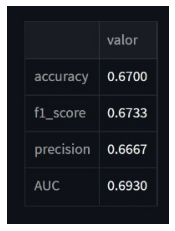

In [23]:
from PIL import Image
import matplotlib.pyplot as plt

# Cargar la imagen
imagen = Image.open("./images/1er_intento.jpg")

# Mostrar la imagen
plt.imshow(imagen)
plt.axis('off')
plt.show()

Este resultado sirve como valor de referencia para poder mejorar el trabajo, e indica que aún se pueden optimizar los resultados obtenidos si se da con el método adecuado.

# 2º intento del Challenge

## 1er método


### Para continuar con  la aplicación de clasificadores que permitan diferenciar entre los 2 tipos de tumores, se aplica Random Forest para obtener las importancias a la hora de clasificar de cada característica.

Se realizan 1000 Random Forest (sin establecer semilla), y se almacenan los indices de las 20 características más importantes en cada Random Forest.

In [8]:
datos_train

,10Percentile_T1,10Percentile_Flair,10Percentile_t1wce,90Percentile_T1,90Percentile_Flair,90Percentile_t1wce,Energy_T1,Energy_Flair,Energy_t1wce,Entropy_T1,...,LowGrayLevelEmphasis_t1wce_wavelet,SmallDependenceEmphasis_T1_wavelet,SmallDependenceEmphasis_Flair_wavelet,SmallDependenceEmphasis_t1wce_wavelet,SmallDependenceHighGrayLevelEmphasis_T1_wavelet,SmallDependenceHighGrayLevelEmphasis_Flair_wavelet,SmallDependenceHighGrayLevelEmphasis_t1wce_wavelet,SmallDependenceLowGrayLevelEmphasis_T1_wavelet,SmallDependenceLowGrayLevelEmphasis_Flair_wavelet,SmallDependenceLowGrayLevelEmphasis_t1wce_wavelet
0,107.0,137.0,28346687.0,1.148016,15.0,3.269895,161.0,9.507846,119.574414,118.0,...,1920.449541,0.010589,3.967890,72.992864,291.930173,18.258537,0.258028,0.024673,0.068876,0.013622
1,91.0,110.0,14504955.0,1.156347,10.0,8.218238,116.0,6.551715,99.844075,100.0,...,1415.271656,0.009608,3.970894,72.854470,291.376299,18.224012,0.257277,0.023456,0.067837,0.012361
2,68.0,97.0,10945975.0,1.029655,14.0,2.453209,111.0,8.234437,83.974493,84.0,...,1495.378025,0.010995,3.966645,72.775016,291.054938,18.205036,0.258339,0.024789,0.068743,0.013800
3,144.0,177.0,86205891.0,1.280874,17.0,3.333962,203.0,10.036525,159.901791,159.0,...,3280.731343,0.010339,3.968657,75.189254,300.714925,18.807836,0.257836,0.023403,0.064953,0.013015
4,55.7,119.0,11725863.0,1.288423,12.0,7.025549,130.0,18.064797,100.717069,110.0,...,1062.118738,0.007366,3.977737,73.552876,294.189239,18.393785,0.255566,0.022041,0.065902,0.011076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,49.0,90.0,7995831.0,1.439455,22.0,2.656860,112.0,12.603046,66.995863,64.5,...,1660.302600,0.009367,3.971631,73.403073,293.583924,18.357861,0.257092,0.024056,0.067857,0.013106
380,86.0,143.0,10707616.0,1.807054,25.0,2.672286,159.0,16.129984,114.158291,115.0,...,786.062814,0.006242,3.981156,70.788945,283.136935,17.701947,0.254711,0.022417,0.070824,0.010315
381,68.0,94.0,10867662.0,1.121760,14.0,3.863095,126.0,8.729883,81.105490,80.0,...,1571.771129,0.015185,3.953732,72.131400,288.446021,18.052745,0.261567,0.027468,0.071932,0.016352
382,99.0,173.0,10511706.0,2.219147,37.0,2.577685,195.0,22.152598,134.897297,134.0,...,553.003604,0.001799,3.994595,68.340541,273.356757,17.086486,0.251351,0.018857,0.070022,0.006066


Se elige 2a columna únicamente.

In [10]:
train_label

,BraTS21ID,MGMT_value
0,0,0
1,2,0
2,5,0
3,6,1
4,8,1
...,...,...
379,680,0
380,682,0
381,683,0
382,684,0


In [15]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

train_label = train_label['MGMT_value']


indices_rf = []

for i in range(1000):

    rf_imp = RandomForestClassifier()

    rf_imp.fit(datos_train, train_label)

    importances = rf_imp.feature_importances_
    indices = list(np.argsort(importances)[::-1])[:20]
    indices_rf.append(indices)


Se realiza un conteo de las características que más aparecen entre las 20 más importantes, y el número de apariciones.

In [16]:
from collections import Counter


# Aplanar la lista de listas
lista_aplanada = [item for sublist in indices_rf for item in sublist]

# Contar la frecuencia de cada elemento
conteo = Counter(lista_aplanada)

print(conteo.most_common(20))


# Extraer solo los elementos de las tuplas
elementos = [elemento for elemento, frecuencia in conteo.most_common(20)]

# Mostrar la lista de elementos
print(elementos)

[(125, 1000), (553, 1000), (446, 1000), (232, 1000), (339, 1000), (18, 1000), (21, 924), (556, 922), (128, 915), (449, 913), (342, 909), (235, 902), (402, 653), (27, 606), (241, 572), (348, 569), (562, 568), (134, 556), (455, 539), (509, 236)]
[125, 553, 446, 232, 339, 18, 21, 556, 128, 449, 342, 235, 402, 27, 241, 348, 562, 134, 455, 509]


En los datos de train, se realizan particiones de train y test para evaluar modelos, puesto que no se poseen etiquetas para los datos de test reales

In [18]:
# inx_filt = [num for num in indices if num <= 284]

from sklearn.metrics import accuracy_score


X_train_imp = datos_train.head(284)
X_test_imp = datos_train.tail(100)
y_train_imp = train_label.head(284)
y_test_imp = train_label.tail(100)

acc = []

# from sklearn.preprocessing import MinMaxScaler
# 
# scaler = MinMaxScaler()
# funciona peor normalizando

# for i in 
for j in range(20):
    for i in range(1,len(elementos)+1):

        idx_filt = elementos[:i]

        X_train_imp_ = X_train_imp.iloc[:, idx_filt]
        X_test_imp_ = X_test_imp.iloc[:, idx_filt]

        # X_train_imp_ = pd.DataFrame(scaler.fit_transform(X_train_imp_), columns=X_train_imp_.columns)
        # X_test_imp_ = pd.DataFrame(scaler.fit_transform(X_test_imp.iloc[:, idx_filt]), columns=X_test_imp.iloc[:, idx_filt].columns)

        rf = RandomForestClassifier()
        rf.fit(X_train_imp_, y_train_imp)

        y_pred = rf.predict(X_test_imp_)

        # LR = LogisticRegression()
        # LR.fit(X_train_imp_, y_train_imp)

        # y_pred = LR.predict(X_test_imp.iloc[:, idx_filt])

        acc.append([i, accuracy_score(y_test_imp, y_pred)])

Se obtiene el número de caracteristicas para las cuales se asocia una mayor precisión media

In [ ]:
acc_df = pd.DataFrame(acc)

acc_df.columns = ['numero', 'precision']
acc_df

media_precision = pd.DataFrame(acc_df.groupby('numero')['precision'].mean())
media_precision

max_precision = media_precision['precision'].max()
max_precision_index = media_precision['precision'].idxmax()

print(f"El mayor valor en la columna 'precision' es {max_precision} y su índice es {max_precision_index}")



El mayor valor en la columna 'precision' es 0.9315 y su índice es 20


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score


idx_filt = indices[:max_precision_index]

X_train_met = datos_train.head(300).iloc[:, idx_filt]
X_test_met = datos_train.head(84).iloc[:, idx_filt]
y_train_met = train_label.head(300)
y_test_met = train_label.tail(84)

rf = RandomForestClassifier()
rf.fit(X_train_met, y_train_met)

y_pred_train = rf.predict(X_train_met)
y_pred_test = rf.predict(X_test_met)

y_proba_train = rf.predict_proba(X_train_met)[:, 1]
y_proba_test = rf.predict_proba(X_test_met)[:, 1]

acc_train = accuracy_score(y_train_met, y_pred_train)
acc_test = accuracy_score(y_test_met, y_pred_test)

auc_train = roc_auc_score(y_train_met, y_proba_train)
auc_test = roc_auc_score(y_test_met, y_proba_test)

print('Precision train: ', acc_train)
print('AUC train: ', acc_test)
print('Precision test: ', auc_train)
print('AUC test: ', auc_test)

Precision train:  1.0
AUC train:  0.40476190476190477
Precision test:  1.0
AUC test:  0.41029327199539967


Se realiza predicción de Random Forest con los las características con más apariciones como más importantes y que mejor precisión ofrecen en promedio

In [ ]:

idx_filt = indices[:max_precision_index]

X_train_imp2 = datos_train.iloc[:, idx_filt]
X_test_imp2 = datos_test.iloc[:, idx_filt]
y_train_imp2 = train_label.copy()

rf = RandomForestClassifier()
rf.fit(X_train_imp2, y_train_imp2)

y_pred = rf.predict(X_test_imp2)

y_pred_proba = rf.predict_proba(X_test_imp2)

Para comprobar, se compara con el primer intento realizado

In [ ]:

ycsv = pd.read_csv('grupo_04_1er_intento.csv')


print('Similitud: ', accuracy_score(y_true = ycsv['MGMT_value'], y_pred=y_pred))


Similitud:  0.65


Con una similitud de 65%, puede haber indicios de que la nueva predicción es mejor, ya que la precisión del primer intento también acertaba alrededor de un 65%

Se almacena esta predicción, para comparar posteriormente con otro método y tener mejor confianza sobre la mejora de los resultados

In [ ]:
df_pred['MGMT_value'] = y_pred
df_pred['MGMT_prob'] = np.round(y_pred_proba[:, 1],2)
df_pred


df_pred.to_csv('grupo_04_caye.csv', index=False)

## 2º método

Ahora la selección de características se hace con el método Relief anterior, y la clasificación con TPOT. TPOT es una herramienta de automatización de aprendizaje automático que utiliza algoritmos para construir pipelines de aprendizaje automático óptimos. Ayuda a simplificar el proceso de búsqueda, contemplando firentes modelos e hiperparámetros buscando aquel que sea más óptimo.

In [17]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Separar los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(datos_train_relief, y, test_size=0.2, random_state=42)

# Crear una instancia de TPOTClassifier
tpot = TPOTClassifier(generations=10, population_size=10, verbosity=2)

# Entrenar el modelo
tpot.fit(X_train, y_train)

# Calcular la precisión en los conjuntos de entrenamiento y prueba
y_train_pred = tpot.predict(X_train)
y_test_pred = tpot.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Calcular el área bajo la curva (AUC) en los conjuntos de entrenamiento y prueba
y_train_proba = tpot.predict_proba(X_train)[:, 1]
y_test_proba = tpot.predict_proba(X_test)[:, 1]

train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

print("Train AUC:", train_auc)
print("Test AUC:", test_auc)

Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8716981132075471

Generation 2 - Current best internal CV score: 0.8716981132075471

Generation 3 - Current best internal CV score: 0.8716981132075471

Generation 4 - Current best internal CV score: 0.8754716981132076

Generation 5 - Current best internal CV score: 0.879245283018868

Generation 6 - Current best internal CV score: 0.879245283018868

Generation 7 - Current best internal CV score: 0.8943396226415097

Generation 8 - Current best internal CV score: 0.8943396226415097

Generation 9 - Current best internal CV score: 0.8943396226415097

Generation 10 - Current best internal CV score: 0.8943396226415097

Best pipeline: RandomForestClassifier(DecisionTreeClassifier(input_matrix, criterion=entropy, max_depth=8, min_samples_leaf=10, min_samples_split=18), bootstrap=True, criterion=gini, max_features=0.55, min_samples_leaf=13, min_samples_split=20, n_estimators=100)
Train Accuracy: 0.9245283018867925
Test Accuracy: 0.850746268656716

c:\Users\Cayetano\anaconda3\envs\CDBIO\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\Cayetano\anaconda3\envs\CDBIO\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\Cayetano\anaconda3\envs\CDBIO\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\Cayetano\anaconda3\envs\CDBIO\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\Cayetano\anaconda3\envs\CDBIO\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warni

Se obtiene que el mejor modelo será :

RandomForestClassifier(DecisionTreeClassifier(input_matrix, criterion=entropy, max_depth=8, min_samples_leaf=10, min_samples_split=18), bootstrap=True, criterion=gini, max_features=0.55, min_samples_leaf=13, min_samples_split=20, n_estimators=100)

In [19]:
tpot.fitted_pipeline_.fit(datos_train_relief, y)


# Cargar los datos de prueba
X_test_pred = datos_test_relief

# Realizar las predicciones en los datos de prueba utilizando el modelo TPOT entrenado

y_test_pred_proba = tpot.fitted_pipeline_.predict_proba(X_test_pred)
print("Probabilidades de predicción en los datos de prueba:")
print(y_test_pred_proba)
import pandas as pd
import numpy as np

# Obtener la etiqueta predicha basada en la probabilidad mayoritaria
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

# Crear un DataFrame con los datos de prueba y las etiquetas y probabilidades predichas
predicciones = pd.DataFrame({'BraTS21ID': datos_test_relief.index, 'MGMT_value': y_test_pred, 'MGMT_prob': y_test_pred_proba[:, 1]})
predicciones
# Guardar el DataFrame en un archivo CSV
# predicciones.to_csv('pred_tpot_2_OK.csv', index=False)

Probabilidades de predicción en los datos de prueba:
[[5.67850572e-02 9.43214943e-01]
 [2.73843270e-02 9.72615673e-01]
 [2.54514052e-01 7.45485948e-01]
 [1.00000000e+00 0.00000000e+00]
 [6.66122866e-02 9.33387713e-01]
 [1.00000000e+00 0.00000000e+00]
 [5.42214912e-03 9.94577851e-01]
 [9.96628503e-01 3.37149692e-03]
 [9.99565217e-01 4.34782609e-04]
 [9.99087302e-01 9.12698413e-04]
 [3.12500000e-04 9.99687500e-01]
 [9.97013228e-01 2.98677249e-03]
 [6.45406209e-01 3.54593791e-01]
 [9.96461039e-01 3.53896104e-03]
 [9.98636364e-01 1.36363636e-03]
 [2.64470899e-02 9.73552910e-01]
 [8.42887628e-03 9.91571124e-01]
 [4.42308822e-01 5.57691178e-01]
 [9.97513228e-01 2.48677249e-03]
 [8.12889991e-01 1.87110009e-01]
 [2.07406597e-02 9.79259340e-01]
 [5.83541317e-01 4.16458683e-01]
 [9.94097700e-01 5.90230037e-03]
 [9.94985646e-01 5.01435407e-03]
 [4.57889621e-03 9.95421104e-01]
 [9.97666667e-01 2.33333333e-03]
 [3.12500000e-04 9.99687500e-01]
 [6.50225598e-01 3.49774402e-01]
 [9.98253968e-01 1.7460

c:\Users\Cayetano\anaconda3\envs\CDBIO\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\Cayetano\anaconda3\envs\CDBIO\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\Cayetano\anaconda3\envs\CDBIO\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\Cayetano\anaconda3\envs\CDBIO\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


,BraTS21ID,MGMT_value,MGMT_prob
0,384,1,0.943215
1,385,1,0.972616
2,386,1,0.745486
3,387,0,0.000000
4,388,1,0.933388
...,...,...,...
95,479,1,0.997836
96,480,0,0.011816
97,481,1,0.997000
98,482,1,0.714368


## Comparación entre métodos y primer intento

Se realiza comparación entre 1er intento, y los 2 modelos para predicción propuestos

In [ ]:
pred_caye = pd.read_csv('grupo_04_caye.csv')
pred_caye

pred_george = pd.read_csv('pred_tpot_2_OK.csv')
pred_george

print('Similitud Caye vs Jorge: ', sum(pred_caye['MGMT_value'] == pred_george['MGMT_value']) / len(pred_caye['MGMT_value']))
print('Similitud Caye vs 1er intento: ', sum(pred_caye['MGMT_value'] == ycsv['MGMT_value']) / len(pred_caye['MGMT_value']))
print('Similitud Jorge vs 1er intento: ', sum(pred_george['MGMT_value'] == ycsv['MGMT_value']) / len(pred_caye['MGMT_value']))

y_caye = pred_caye['MGMT_value']
y_george = pred_george['MGMT_value']

probs_caye = pred_caye['MGMT_prob']
probs_george = np.round(pred_george['MGMT_prob'],2)

# y_caye == y_george



Similitud Caye vs Jorge:  0.92
Similitud Caye vs 1er intento:  0.63
Similitud Jorge vs 1er intento:  0.65


Los 2 modelos alternativos propuestos tienen gran parecido entre ellos (Caye hace referencia al modelo que usa RF, meintras que Jorge al que emplea ReliefF + TOPT, simplemente porque fue el ordenador en el que se ejecutaron)

Se realiza un estudio para analizar las discrepancias entre ambos

Se muestran los indicies no coincidentes, y la probabilidad asociada a la clase 1 de ambas predicciones

In [ ]:
indices_no_coincidentes = []

for i in range(len(y_caye)):
    if y_caye[i] != y_george[i]:
        indices_no_coincidentes.append(i)

print(indices_no_coincidentes)

print(probs_caye[indices_no_coincidentes])
print(probs_george[indices_no_coincidentes])


[19, 37, 54, 65, 73, 96, 99]
19    0.73
37    0.78
54    0.48
65    0.79
73    0.74
96    0.15
99    0.41
Name: MGMT_prob, dtype: float64
19    0.17
37    0.20
54    0.58
65    0.37
73    0.32
96    0.59
99    0.75
Name: MGMT_prob, dtype: float64


Se obtiene la confianza en la decisión de ambas predicciones en las muestras discrepantes. Esto es la confianza (probabilidad) en predecir la clase que ha sido predicha.

In [ ]:
mayor_prob_caye = [x if x > 0.5 else np.round(1 - x,2) for x in probs_caye[indices_no_coincidentes]]
mayor_prob_jorge = [np.round(1 - x,2) if x < 0.5 else x for x in probs_george[indices_no_coincidentes]]

print('Caye', mayor_prob_caye)
print('Jorge', mayor_prob_jorge)

Caye [0.73, 0.78, 0.52, 0.79, 0.74, 0.85, 0.59]
Jorge [0.83, 0.8, 0.58, 0.63, 0.68, 0.59, 0.75]


Para la predicción conjunta, se eligen las predicciones de los modelos que mayor confianza hayan presentado en cada discrepancia

In [ ]:
ganadores = [0 if mayor_prob_caye[i] > mayor_prob_jorge[i] else 1 for i in range(len(mayor_prob_caye))]
ganadores

[1, 1, 1, 0, 0, 0, 1]

Las muestras donde se asignará el valor de Jorge son las establecidas como 1, y las que se asignará el valor de Cayetano como 0.

In [ ]:
y_pred_final = y_caye.copy()
y_proba_final = probs_caye.copy()
cont = 0

for i in indices_no_coincidentes:
    if ganadores[cont] == 1:
        y_pred_final[i] = y_george[i]
        y_proba_final[i] = probs_george[i]
    else:
        y_pred_final[i] = y_pred_final[i]
        y_proba_final[i] = y_proba_final[i]
    cont = cont + 1


Se importa de nuevo el df base de predicción, y se asigna las predicciones y las probabilidades de clase 1 finales, tras la elección de discrepancias en función de la confianza

In [ ]:
df_pred = pd.read_csv('grupo_XX.csv')
import numpy as np

df_pred['MGMT_value'] = y_pred_final
df_pred['MGMT_prob'] = y_proba_final
df_pred

,BraTS21ID,MGMT_value,MGMT_prob
0,686,1,0.74
1,687,1,0.93
2,688,1,0.99
3,690,0,0.02
4,691,1,0.76
...,...,...,...
95,1005,1,1.00
96,1007,0,0.15
97,1008,1,0.88
98,1009,1,0.94


In [ ]:
# df_pred.to_csv('grupo_04.csv', index=False)


## Resultados 2º intento

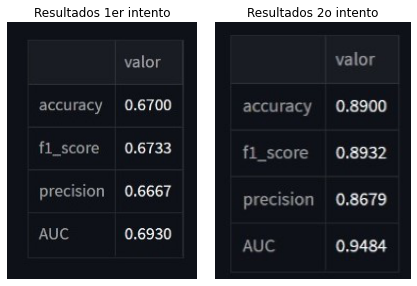

In [27]:
result1 = Image.open("./images/1er_intento.jpg")
result2 = Image.open("./images/2o_intento.jpg")

fig, axs = plt.subplots(1, 2)

axs[0].imshow(result1)
axs[0].axis('off')
axs[0].set_title("Resultados 1er intento")


axs[1].imshow(result2)
axs[1].axis('off')
axs[1].set_title("Resultados 2o intento")


plt.tight_layout()

plt.show()

Se logra sumar al menos un 20% en todas las métricas de relevancia, de modo que se evidencia la gran mejora que se logra con este segundo intento.

# 3er intento del Challenge

Ahora se trata de aplciar ReliefF y combinarlo con TPOT pero de una manera más exhaustiva, contemplando reducir de 2 a 20 característcias y aplicando TPOT en cada caso, buscando reducir al número óptimo de características.

In [28]:
import matplotlib.pyplot as plt
from skrebate import ReliefF

# Realizar ReliefF con diferentes números de características
num_caracteristicas = list(range(2, 21))

train_accuracy_list = []
test_accuracy_list = []
train_auc_list = []
test_auc_list = []

# Crear una instancia del clasificador ReliefF
relief = ReliefF(n_features_to_select=max(num_caracteristicas))

# Aplicar el algoritmo Relief a todo el conjunto de datos
X_relief = relief.fit_transform(datos_train_filtered.values, y)

# Obtener los nombres de todas las características seleccionadas por ReliefF
nombres_seleccionados = datos_train_filtered.columns[relief.top_features_]

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from tpot import TPOTClassifier

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from tpot import TPOTClassifier

# Rest of your code...

for num in num_caracteristicas:
    if num <= datos_train_filtered.shape[1]:
        # Obtener las características seleccionadas según el número deseado
        caracteristicas_seleccionadas = nombres_seleccionados[:num]

        # Crear un DataFrame con las características seleccionadas por ReliefF
        datos_relief = pd.DataFrame(X_relief[:, :num], columns=caracteristicas_seleccionadas)

        print("Features selected for ReliefF with", num, "features:")
        print(datos_relief.shape)

        # Separar los datos en conjuntos de entrenamiento y prueba
        X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(datos_relief, y, test_size=0.2, random_state=42)

        # Crear una instancia de TPOTClassifier
        tpot = TPOTClassifier(generations=10, population_size=10, verbosity=2)

        # Entrenar el modelo
        tpot.fit(X_train_rf, y_train_rf)

        # Calcular la precisión en los conjuntos de entrenamiento y prueba
        y_train_pred = tpot.predict(X_train_rf)
        y_test_pred = tpot.predict(X_test_rf)

        train_accuracy = accuracy_score(y_train_rf, y_train_pred)
        test_accuracy = accuracy_score(y_test_rf, y_test_pred)

        train_accuracy_list.append(train_accuracy)
        test_accuracy_list.append(test_accuracy)

        # Calcular el área bajo la curva (AUC) en los conjuntos de entrenamiento y prueba
        if hasattr(tpot, "predict_proba"):
            y_train_proba = tpot.predict_proba(X_train_rf)[:, 1]
            y_test_proba = tpot.predict_proba(X_test_rf)[:, 1]

            train_auc = roc_auc_score(y_train_rf, y_train_proba)
            test_auc = roc_auc_score(y_test_rf, y_test_proba)
        else:
            train_auc = 0
            test_auc = 0

        train_auc_list.append(train_auc)
        test_auc_list.append(test_auc)

        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        print("Train AUC:", train_auc)
        print("Test AUC:", test_auc)


Features selected for ReliefF with 2 features:
(332, 2)


Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.879245283018868

Generation 2 - Current best internal CV score: 0.879245283018868

Generation 3 - Current best internal CV score: 0.879245283018868

Generation 4 - Current best internal CV score: 0.8867924528301888

Generation 5 - Current best internal CV score: 0.8867924528301888

Generation 6 - Current best internal CV score: 0.8867924528301888

Generation 7 - Current best internal CV score: 0.8867924528301888

Generation 8 - Current best internal CV score: 0.8867924528301888

Generation 9 - Current best internal CV score: 0.8867924528301888

Generation 10 - Current best internal CV score: 0.8867924528301888

Best pipeline: RandomForestClassifier(CombineDFs(input_matrix, Normalizer(RBFSampler(input_matrix, gamma=0.5), norm=l1)), bootstrap=False, criterion=entropy, max_features=0.9500000000000001, min_samples_leaf=15, min_samples_split=13, n_estimators=100)
Train Accuracy: 0.9169811320754717
Test Accuracy: 0.835820895522388
Train AUC: 

Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8603773584905661

Generation 2 - Current best internal CV score: 0.8716981132075471

Best pipeline: ExtraTreesClassifier(PCA(input_matrix, iterated_power=6, svd_solver=randomized), bootstrap=True, criterion=gini, max_features=0.1, min_samples_leaf=6, min_samples_split=9, n_estimators=100)
Train Accuracy: 0.8679245283018868
Test Accuracy: 0.8507462686567164
Train AUC: 0.9531214399635453
Test AUC: 0.9331550802139038
Features selected for ReliefF with 4 features:
(332, 4)


Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8867924528301888

Generation 2 - Current best internal CV score: 0.8867924528301888

Generation 3 - Current best internal CV score: 0.8867924528301888

Generation 4 - Current best internal CV score: 0.8867924528301888

Generation 5 - Current best internal CV score: 0.8905660377358492

Generation 6 - Current best internal CV score: 0.8981132075471698

Generation 7 - Current best internal CV score: 0.8981132075471698

Generation 8 - Current best internal CV score: 0.8981132075471698

Generation 9 - Current best internal CV score: 0.8981132075471698

Generation 10 - Current best internal CV score: 0.9018867924528303

Best pipeline: ExtraTreesClassifier(SelectFwe(KNeighborsClassifier(DecisionTreeClassifier(input_matrix, criterion=entropy, max_depth=5, min_samples_leaf=4, min_samples_split=19), n_neighbors=48, p=2, weights=uniform), alpha=0.02), bootstrap=True, criterion=gini, max_features=1.0, min_samples_leaf=10, min_samples_split=15, n_es

C:\Users\34722\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\34722\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\34722\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\34722\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\34722\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\34722\anaconda3\lib\site-packages\sklearn\base.py:4

Train Accuracy: 0.9245283018867925
Test Accuracy: 0.8955223880597015
Train AUC: 0.9868136249715198
Test AUC: 0.9278074866310161
Features selected for ReliefF with 5 features:
(332, 5)


Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8905660377358491

Generation 2 - Current best internal CV score: 0.8905660377358491

Generation 3 - Current best internal CV score: 0.8905660377358491

Generation 4 - Current best internal CV score: 0.8905660377358491

Generation 5 - Current best internal CV score: 0.8905660377358491

Generation 6 - Current best internal CV score: 0.8905660377358491

Generation 7 - Current best internal CV score: 0.8905660377358491

Generation 8 - Current best internal CV score: 0.8905660377358491

Generation 9 - Current best internal CV score: 0.8905660377358491

Generation 10 - Current best internal CV score: 0.9056603773584907

Best pipeline: ExtraTreesClassifier(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), bootstrap=True, criterion=entropy, max_features=1.0, min_samples_leaf=2, min_samples_split=7, n_estimators=100)
Train Accuracy: 0.9471698113207547
Test Accuracy: 0.8805970149253731
Train AUC: 0.9942469810

Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8830188679245283

Best pipeline: GradientBoostingClassifier(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), learning_rate=0.1, max_depth=10, max_features=0.55, min_samples_leaf=4, min_samples_split=16, n_estimators=100, subsample=0.35000000000000003)
Train Accuracy: 0.9886792452830189
Test Accuracy: 0.8656716417910447
Train AUC: 0.9993164730006836
Test AUC: 0.9376114081996435
Features selected for ReliefF with 7 features:
(332, 7)


Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8679245283018868

Generation 2 - Current best internal CV score: 0.8716981132075471

Generation 3 - Current best internal CV score: 0.8716981132075471

Generation 4 - Current best internal CV score: 0.8716981132075471

Generation 5 - Current best internal CV score: 0.8867924528301888

Generation 6 - Current best internal CV score: 0.8867924528301888

Generation 7 - Current best internal CV score: 0.8867924528301888

Generation 8 - Current best internal CV score: 0.8867924528301888

Generation 9 - Current best internal CV score: 0.8867924528301888

Generation 10 - Current best internal CV score: 0.8867924528301888

Best pipeline: LinearSVC(RBFSampler(MinMaxScaler(input_matrix), gamma=0.5), C=10.0, dual=False, loss=squared_hinge, penalty=l1, tol=0.01)
Train Accuracy: 0.8943396226415095
Test Accuracy: 0.835820895522388
Train AUC: 0
Test AUC: 0
Features selected for ReliefF with 8 features:
(332, 8)


Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8754716981132077

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=10, max_features=0.7000000000000001, min_samples_leaf=10, min_samples_split=2, n_estimators=100, subsample=0.8)
Train Accuracy: 1.0
Test Accuracy: 0.8805970149253731
Train AUC: 1.0
Test AUC: 0.9438502673796791
Features selected for ReliefF with 9 features:
(332, 9)


Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8943396226415095

Best pipeline: DecisionTreeClassifier(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), criterion=entropy, max_depth=9, min_samples_leaf=9, min_samples_split=17)
Train Accuracy: 0.939622641509434
Test Accuracy: 0.8955223880597015
Train AUC: 0.988835725677831
Test AUC: 0.8983957219251337
Features selected for ReliefF with 10 features:
(332, 10)


Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8679245283018868

Generation 2 - Current best internal CV score: 0.8754716981132076

Generation 3 - Current best internal CV score: 0.8905660377358491

Generation 4 - Current best internal CV score: 0.8905660377358491

Generation 5 - Current best internal CV score: 0.8905660377358491

Generation 6 - Current best internal CV score: 0.8905660377358491

Generation 7 - Current best internal CV score: 0.8905660377358491

Generation 8 - Current best internal CV score: 0.8905660377358491

Generation 9 - Current best internal CV score: 0.8905660377358491

Generation 10 - Current best internal CV score: 0.8905660377358491

Best pipeline: LinearSVC(DecisionTreeClassifier(input_matrix, criterion=entropy, max_depth=3, min_samples_leaf=4, min_samples_split=2), C=10.0, dual=False, loss=squared_hinge, penalty=l1, tol=0.0001)


C:\Users\34722\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\34722\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\34722\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\34722\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Train Accuracy: 0.909433962264151
Test Accuracy: 0.8507462686567164
Train AUC: 0
Test AUC: 0
Features selected for ReliefF with 11 features:
(332, 11)


Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.879245283018868

Generation 2 - Current best internal CV score: 0.8867924528301886

Generation 3 - Current best internal CV score: 0.8867924528301886

Generation 4 - Current best internal CV score: 0.8867924528301886

Generation 5 - Current best internal CV score: 0.8867924528301886

Generation 6 - Current best internal CV score: 0.8867924528301886

Generation 7 - Current best internal CV score: 0.8867924528301886

Generation 8 - Current best internal CV score: 0.8867924528301886

Generation 9 - Current best internal CV score: 0.8867924528301886

Generation 10 - Current best internal CV score: 0.8867924528301886

Best pipeline: DecisionTreeClassifier(input_matrix, criterion=entropy, max_depth=4, min_samples_leaf=19, min_samples_split=5)
Train Accuracy: 0.9132075471698113
Test Accuracy: 0.8656716417910447
Train AUC: 0.9694691273638641
Test AUC: 0.9229055258467024
Features selected for ReliefF with 12 features:
(332, 12)


Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.879245283018868

Generation 2 - Current best internal CV score: 0.879245283018868

Generation 3 - Current best internal CV score: 0.879245283018868

Generation 4 - Current best internal CV score: 0.8830188679245283

Generation 5 - Current best internal CV score: 0.8867924528301888

Generation 6 - Current best internal CV score: 0.8943396226415097

Generation 7 - Current best internal CV score: 0.8943396226415097

Generation 8 - Current best internal CV score: 0.8943396226415097

Generation 9 - Current best internal CV score: 0.8943396226415097

Generation 10 - Current best internal CV score: 0.8943396226415097

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=6, max_features=0.3, min_samples_leaf=9, min_samples_split=9, n_estimators=100, subsample=0.55)
Train Accuracy: 1.0
Test Accuracy: 0.8507462686567164
Train AUC: 1.0
Test AUC: 0.928698752228164
Features selected for ReliefF with 13 features:
(332,

Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8867924528301888

Best pipeline: DecisionTreeClassifier(input_matrix, criterion=entropy, max_depth=4, min_samples_leaf=15, min_samples_split=14)
Train Accuracy: 0.9169811320754717
Test Accuracy: 0.8507462686567164
Train AUC: 0.9730291638186376
Test AUC: 0.9153297682709447
Features selected for ReliefF with 14 features:
(332, 14)


Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.879245283018868

Generation 2 - Current best internal CV score: 0.879245283018868

Generation 3 - Current best internal CV score: 0.8830188679245282

Generation 4 - Current best internal CV score: 0.8943396226415095

Generation 5 - Current best internal CV score: 0.8943396226415095

Generation 6 - Current best internal CV score: 0.8981132075471698

Generation 7 - Current best internal CV score: 0.9056603773584907

Generation 8 - Current best internal CV score: 0.9056603773584907

Generation 9 - Current best internal CV score: 0.9056603773584907

Generation 10 - Current best internal CV score: 0.9056603773584907

Best pipeline: DecisionTreeClassifier(RFE(input_matrix, criterion=gini, max_features=0.9000000000000001, n_estimators=100, step=0.45), criterion=entropy, max_depth=4, min_samples_leaf=12, min_samples_split=7)
Train Accuracy: 0.9056603773584906
Test Accuracy: 0.8507462686567164
Train AUC: 0.9760480747322853
Test AUC: 0.8850267379

Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8905660377358491

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.2, min_samples_leaf=1, min_samples_split=13, n_estimators=100)
Train Accuracy: 1.0
Test Accuracy: 0.835820895522388
Train AUC: 1.0
Test AUC: 0.9081996434937611
Features selected for ReliefF with 16 features:
(332, 16)


Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Best pipeline: RandomForestClassifier(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), bootstrap=False, criterion=gini, max_features=0.8500000000000001, min_samples_leaf=5, min_samples_split=15, n_estimators=100)
Train Accuracy: 0.9471698113207547
Test Accuracy: 0.8805970149253731
Train AUC: 0.9955855547960811
Test AUC: 0.8810160427807485
Features selected for ReliefF with 17 features:
(332, 17)


Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=5, max_features=0.2, min_samples_leaf=13, min_samples_split=3, n_estimators=100, subsample=0.9000000000000001)
Train Accuracy: 1.0
Test Accuracy: 0.8208955223880597
Train AUC: 1.0
Test AUC: 0.9197860962566845
Features selected for ReliefF with 18 features:
(332, 18)


Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Best pipeline: ExtraTreesClassifier(VarianceThreshold(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), threshold=0.01), bootstrap=False, criterion=gini, max_features=0.6000000000000001, min_samples_leaf=13, min_samples_split=15, n_estimators=100)
Train Accuracy: 0.9320754716981132
Test Accuracy: 0.8507462686567164
Train AUC: 0.9817726133515606
Test AUC: 0.9438502673796791
Features selected for ReliefF with 19 features:
(332, 19)


Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8867924528301888

Generation 2 - Current best internal CV score: 0.8867924528301888

Generation 3 - Current best internal CV score: 0.8867924528301888

Generation 4 - Current best internal CV score: 0.8867924528301888

Generation 5 - Current best internal CV score: 0.8867924528301888

Generation 6 - Current best internal CV score: 0.9056603773584906

Generation 7 - Current best internal CV score: 0.9056603773584906

Generation 8 - Current best internal CV score: 0.9056603773584906

Generation 9 - Current best internal CV score: 0.9056603773584906

Generation 10 - Current best internal CV score: 0.9056603773584906

Best pipeline: ExtraTreesClassifier(RobustScaler(RFE(GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=3, max_features=0.6500000000000001, min_samples_leaf=16, min_samples_split=20, n_estimators=100, subsample=0.9500000000000001), criterion=entropy, max_features=0.2, n_estimators=100, step=1.0)), bootstrap=

C:\Users\34722\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\34722\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\34722\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\34722\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\34722\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\34722\anaconda3\lib\site-packag

Train Accuracy: 1.0
Test Accuracy: 0.8656716417910447
Train AUC: 1.0
Test AUC: 0.9024064171122994
Features selected for ReliefF with 20 features:
(332, 20)


Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Best pipeline: DecisionTreeClassifier(input_matrix, criterion=entropy, max_depth=5, min_samples_leaf=6, min_samples_split=18)
Train Accuracy: 0.9283018867924528
Test Accuracy: 0.8059701492537313
Train AUC: 0.9852187286397812
Test AUC: 0.8600713012477719


Algunos algoritmos de clasificación no permiten emplear predict_proba(), de modo que en los casos en que este algoritmo es el óptimo no es posible obtener el AUC y ROC asociado. 

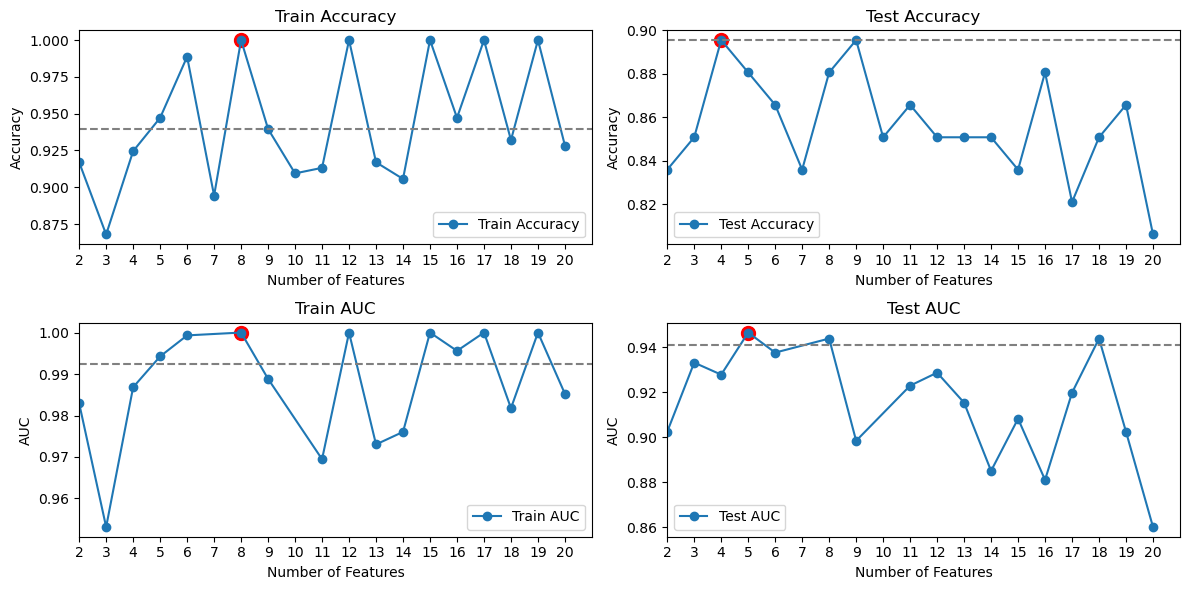

In [ ]:
import matplotlib.pyplot as plt

# Filtrar los valores diferentes de cero para AUC y ROC
x_auc = [x for x, auc in zip(num_caracteristicas, train_auc_list) if auc != 0]
x_roc = [x for x, roc in zip(num_caracteristicas, test_auc_list) if roc != 0]

# Filtrar los valores diferentes de cero para AUC y ROC
train_auc_filtered = [auc for auc in train_auc_list if auc != 0]
test_auc_filtered = [auc for auc in test_auc_list if auc != 0]

# Graficar las métricas
plt.figure(figsize=(12, 6))

# Train Accuracy
plt.subplot(2, 2, 1)
plt.plot(num_caracteristicas, train_accuracy_list, marker='o', label='Train Accuracy')
plt.scatter(num_caracteristicas[train_accuracy_list.index(max(train_accuracy_list))],
            max(train_accuracy_list), marker='o', s=100, color='red')
plt.axhline(y=0.939622641509434, color='gray', linestyle='--')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Train Accuracy')
plt.xlim(2, 21)
plt.xticks(range(2, 21))

plt.legend()

# Test Accuracy
plt.subplot(2, 2, 2)
plt.plot(num_caracteristicas, test_accuracy_list, marker='o', label='Test Accuracy')
plt.scatter(num_caracteristicas[test_accuracy_list.index(max(test_accuracy_list))],
            max(test_accuracy_list), marker='o', s=100, color='red')
plt.axhline(y=0.8955223880597015, color='gray', linestyle='--')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.xlim(2, 21)
plt.xticks(range(2, 21))

plt.legend()

# Train AUC
plt.subplot(2, 2, 3)
plt.plot(x_auc, train_auc_filtered, marker='o', label='Train AUC')
plt.scatter(x_auc[train_auc_filtered.index(max(train_auc_filtered))],
            max(train_auc_filtered), marker='o', s=100, color='red')
plt.axhline(y=0.9923957621326042, color='gray', linestyle='--')
plt.xlabel('Number of Features')
plt.ylabel('AUC')
plt.title('Train AUC')
plt.xlim(2, 21)
plt.xticks(range(2, 21))
plt.legend()

# Test AUC
plt.subplot(2, 2, 4)
plt.plot(x_roc, test_auc_filtered, marker='o', label='Test AUC')
plt.scatter(x_roc[test_auc_filtered.index(max(test_auc_filtered))],
            max(test_auc_filtered), marker='o', s=100, color='red')
plt.axhline(y=0.9411764705882353, color='gray', linestyle='--')
plt.xlabel('Number of Features')
plt.ylabel('AUC')
plt.title('Test AUC')
plt.xlim(2, 21)
plt.xticks(range(2, 21))
plt.legend()

# Ajustar espaciado entre subplots
plt.tight_layout()

# Mostrar la gráfica
plt.show()


La linea horizontal gris marca en cada caso el valor óptimo obtenido empleando el 2o metodo del segundo intento del Challenge, es decir, ReliefF con 10 características y TPOT. Sirve de referencia para los nuevos valores. En rojo se marca el valor máximo de cada métrica de acierto.

Se debería probar con 5 y 8 características en vista de los resultados, pero el modelo óptimo de 5 caracterísitcas resulta imposible de aplibar al combinar ExtraTreesClassifier con PolynomialFeatures y ser de dificil configuración los métodos. Se opta entonces por el modelo que usa 8 características, que es GradientBoostingClassifier(max_depth=10, max_features=0.7000000000000001,min_samples_leaf=10, subsample=0.8)

In [ ]:
num_caract = 8  # Número deseado de características

# Obtener las características seleccionadas según el número deseado
caracteristicas_seleccionadas = nombres_seleccionados[:num_caract]

# Reducir los datos de entrenamiento a las características seleccionadas
datos_relief_train = pd.DataFrame(X_relief[:, :num_caract], columns=caracteristicas_seleccionadas)

print("Features selected for ReliefF with", num_caract, "features:")
print(datos_relief_train.shape)


# Reducir los datos de prueba a las características seleccionadas
datos_test_relief = datos_test[nombres_seleccionados]

# Crear un nuevo DataFrame con las características seleccionadas y sus nombres
datos_test_relief = pd.DataFrame(datos_test_relief, columns=nombres_seleccionados)


print("Features selected for ReliefF with", num_caract, "features:")
print(datos_relief_train.shape)


print("Features selected for ReliefF with", num_caract, "features (Test Data):")
print(datos_test_relief.shape)

# Crear una instancia del modelo GradientBoostingClassifier
model_relief = GradientBoostingClassifier(learning_rate=0.1, max_depth=10, 
                                          max_features=0.7000000000000001, min_samples_leaf=10,
                                          min_samples_split=2, n_estimators=100, subsample=0.8)

# Entrenar el modelo con las características seleccionadas por ReliefF en los datos de entrenamiento
model_relief.fit(datos_relief_train, y)

print("Model trained with ReliefF features:")
print(model_relief)

# Realizar la predicción en los datos de prueba utilizando el modelo entrenado
y_test_pred = model_relief.predict(datos_test_relief)
y_test_pred_proba = model_relief.predict_proba(datos_test_relief)



Features selected for ReliefF with 8 features:
(332, 8)
Features selected for ReliefF with 8 features:
(332, 8)
Features selected for ReliefF with 8 features (Test Data):
(100, 8)
Model trained with ReliefF features:
GradientBoostingClassifier(max_depth=10, max_features=0.7000000000000001,
                           min_samples_leaf=10, subsample=0.8)


In [ ]:
import pandas as pd
import numpy as np

# Obtener la etiqueta predicha basada en la probabilidad mayoritaria
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

# Crear un DataFrame con los datos de prueba y las etiquetas y probabilidades predichas
predicciones = pd.DataFrame({'BraTS21ID': datos_test_relief.index, 'MGMT_value': y_test_pred, 'MGMT_prob': y_test_pred_proba[:, 1]})

# Guardar el DataFrame en un archivo CSV
predicciones.to_csv('pred_tpot_8.csv', index=False)



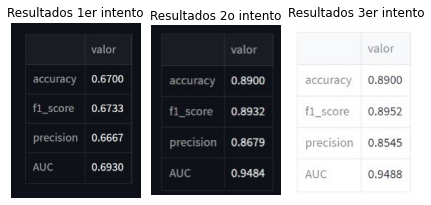

In [34]:
result1 = Image.open("./images/1er_intento.jpg")
result2 = Image.open("./images/2o_intento.jpg")
result3 = Image.open("./images/3er_intento.jpg")

fig, axs = plt.subplots(1, 3)

axs[0].imshow(result1)
axs[0].axis('off')
axs[0].set_title("Resultados 1er intento")


axs[1].imshow(result2)
axs[1].axis('off')
axs[1].set_title("Resultados 2o intento")

axs[2].imshow(result3)
axs[2].axis('off')
axs[2].set_title("Resultados 3er intento")

plt.tight_layout()

plt.show()

Este 3er intento logra mejorar ligeramente f1-score y AUC aunque disminuye un poco la precision. Por otro lado, el valor de acuraccy se mantiene constante. 

## Conclusión 



En este notebook se ha realizado en primer lugar la extracción de características radiómicas, tanto originales como wavelet sobre las tres secuencias de IRM disponibles. 
Posteriormente, se ha realizado un análisis exploratorio de los datos con el fin de estudiar la tipología de variables disponibles. Después, se aplican diferenets métodos para reducir la dimensionalidad de los datos ya que se dispone de 642 características, sindo los mejores resultados para selección de características. Concretamente, los mejores enfoques obtenidos son la selección de características con el método `Relief` y el propio método embedido en el `Random Forest`. En tercer lugar, se implementan los métodos de clasificación de las imágenes, probando entre los disponibles implementados en sklearn. Así mismo, se utiliza la librería `tpot` que busca el mejor modelo con los parámetros óptimos que se ajuste a los datos disponibles. 

En cuanto a los tres intentos realizados en el DataChallenge, el primero de ellos se trata de sobreajuste a los datos de train ya que se utilizó el método LDA para reducción de la dimensionalidad y por sus característcias intrinsecas, solamente se puede reducir a una dimensión. Por ello, aunque este método tenga en cuenta el valor de las etiquetas en la reducción, ha producido un fuerte sobreajuste a los datos de train. Por lo que respecta al segundo intento, se utilza el mejor método que proprociona el algoritmo `tpot` con los parámetros respectivos, dando lugar a un AUC de 0.9484, una gran mejora al métodoa anterior. En este caso se reduce la dimensionalidad con el método `Relief` que trata de alejar las muestras de diferenet clase. Finalmente, en el último intento se realiza una búsqueda más exhuastiva que la que se realizada en el segundo intento. Sin embargo, los resultados obtenidos no consiguen mejorar de manera sustancial el valor del AUC, por lo que el coste computacional asociado a este intento no compensa la mejora y se podría seleccionar como mejor modelo el del segundo intento.



